In [1]:
# dataset
from torchvision import datasets

from functools import partial
import numpy as np

# visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# preprocessing
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# model
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# hyperparameter tuning
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Load Data & Preprocessing

**Dataset**: <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR-10</a>

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The following transformations are tested:
* **normalization**: from [0, 255] to [0, 1]
* **standardization**: by substracting the mean and dividing with std

In [2]:
def load_data(data_dir):
    """ Create train and test pytorch dataset objects from CIFAR-10.
    
    The following tranformations are applied on CIFAR-10:
        * normalization: from [0, 255] to [0, 1] by dividing with 255,
        * standardization: by substracting the mean and dividing with std
    
    Args:
        data_dir:
            directory where data will be saved, as a string.
    
    Returns:
        train and test dataset, as pytorch dataset objects.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
    ])

    trainset = datasets.CIFAR10(root=data_dir,
                                train=True, 
                                download=True, 
                                transform=transform)

    testset = datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=True, 
                               transform=transform)

    return trainset, testset

In [3]:
trainset, testset = load_data(data_dir='cifar10-pytorch')

print(f'\nTraining data:\n--------------\n{trainset}')
print(f'Test data:\n--------------\n{testset}')

Files already downloaded and verified
Files already downloaded and verified

Training data:
--------------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10-pytorch
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )
Test data:
--------------
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: cifar10-pytorch
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))
           )


In [4]:
batch_size = 64

train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# 2. CNN Architecture

This Convolutional Neural Network follows the architecture of LeNet. However, instead of using Tanh activation function and average pooling, **ReLU activation function** and **max pooling** is used. Also, **dropout layers** and **batch normalization layers** have been added.

**Architecture:** Input &#8594; CONV1 &#8594; NORM1 &#8594; ReLU &#8594; POOL2 &#8594; CONV3 &#8594; NORM2 &#8594; ReLU &#8594; POOL4 &#8594; CONV5 &#8594; FC6 &#8594; Softmax

Convolutional layers:
* **CONV1**: 6 filters and kernel size of 5 x 5
* **CONV3**: 16 filters and kernel size of 5 x 5
* **CONV5**:120 filters and kernel size of 5 x 5

Pooling Layers:
* **POOL2, POOL4**: max pooling layers with receptive field of 2 x 2.

Activations:
* ReLU activation function **(hidden layer)**
* Softmax activation function **(output layer)**

Regularization:
* Weight decay (L2 regularization)
* Dropout layers

Normalization:
* Batch normalization

Loss Function:
* Cross Entropy Loss

Optimizer and Scheduler:
* Adam optimizer
* ReduceLROnPlateau scheduler

In [5]:
class CNN(nn.Module):
    """ Convolutional Neural Network for multiclass classification.
    
    This CNN follows the architecture of LeNet. However, instead of using 
    Tanh activation function and average pooling, ReLU activation function 
    and max pooling is used. Also, dropout layers and batch normalization layers have been added.
    
    The CNN architecture is as follows:
    Input → CONV1 → NORM1 → ReLU → POOL2 → CONV3 → NORM2 → ReLU → POOL4 → CONV5 → FC6 → Softmax
    
    The convolutional layers are configured as follows:
    * CONV1: 6 filters and kernel size of 5 x 5
    * CONV3: 16 filters and kernel size of 5 x 5
    * CONV5: 120 filters and kernel size of 5 x 5
    
    The pooling layers are configured as follwos:
    * POOL2, POOL4: max pooling layers with receptive field of 2 x 2.
    
    The hyperparameters of the CNN are:
    * probability of dropout layer.
    
    Arguments:
        in_channels:
            size of input, as an integer.
        output_size:
            size of output (number of labels), as an integer
        p:
            dropout probability, as a float.
    """
    
    def __init__(self, in_channels, output_size, p):
        """ Initialize Convolutional Neural Network.
        
        Args:
            in_channels:
                size of input, as an integer.
            output_size:
                size of output (number of labels), as an integer.
            p:
                dropout probability, as a float.
        """
        super(CNN, self).__init__()
        
        self.in_channels = in_channels
        self.output_size = output_size
        self.p = p
        
        # activation function
        self.activation = nn.ReLU()
        
        # convolutional layer: CONV1
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1)
        # convolutional layer: CONV3
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        
        # max pooling layer 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # dropout layer
        self.dropout = nn.Dropout(p)
        
        # batch normalization layer: NORM1
        self.norm1 = nn.BatchNorm2d(6)
        # batch normalization layer: NORM2
        self.norm2 = nn.BatchNorm2d(16)
        
        # fully connected layers
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=output_size)
        
    def forward(self, x):
        # Input --> CONV1 --> NORM --> ReLU --> POOL2
        pre = self.conv1(x)
        normalized = self.norm1(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # CONV3 → NORM → ReLU → POOL4
        pre = self.conv2(x)
        normalized = self.norm2(pre)
        post = self.activation(normalized)
        x = self.pool(post)
        
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        
        # CONV5
        logits = self.activation(self.fc1(x))
        logits = self.dropout(logits)
        
        # FC6
        logits = self.activation(self.fc2(logits))
        logits = self.dropout(logits)
        
        # outpout
        logits = self.fc3(logits)
        
        return logits

# 3. Hyperparameter Tuning

We'll use **early stopping** with **ASHAScheduler** to stop bad trials earlier.

|                               | Validation Loss | Validation Accuracy |
| :---------------------------: | :-------------: | :-----------------: |
| cnn                           | 0.96            | 67%                 |

Best trial **configuration** for CNN: p: 0.4, lr: 0.001, l2: 0.001

In [6]:
def tune_helper(config, trainset, in_channels, num_labels, batch_size, epochs):
    """ Fit Convolutional Neural Network and test it on a hold-out validation set.
    
    The validation set is a 20% hold-out set of the training set. 
    The loss function used is Cross Entropy Loss.
    The optimer used is Adam and the scheduler that wraps the optimizer is ReduceLROnPlateau.
    The metric used is accuracy score.
    
    Args:
        config:
            hyperparameters of neural network, as a dictionary.
        trainset:
            training dataset, as a pytorch object.
        in_channels:
            number of input channels, as an integer.
        num_labels:
            number of labels, as an integer.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
    """
    model = CNN(in_channels=in_channels,
                output_size=num_labels,
                p=config['p'])
    
    # support data parallel training on multiple GPUs
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)
    
    # loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['l2'])
    
    #scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min')
    
    # split data: training (80%) - validation (20%)
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])

    train_dataloader = DataLoader(train_subset,
                                  batch_size=batch_size,
                                  shuffle=True, 
                                  num_workers=2)
    
    val_dataloader = DataLoader(val_subset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=2)
    
    for epoch in range(epochs):
        # fit neural network on training data
        model.train()  # put on train mode
        for batch, (X, Y) in enumerate(train_dataloader, 0):
            # send the data to the GPU memory explicitly
            X, Y = X.to(device), Y.to(device)

            # reset the gradients
            optimizer.zero_grad()
            
            # compute prediction
            pred = model(X)

            # compute loss
            loss = loss_fn(pred, Y)

            # backpropagate
            loss.backward()

            # update parameters
            optimizer.step()
        
        # test on validation data
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        model.eval()  # put on evaluation mode
        for batch, (X, Y) in enumerate(val_dataloader, 0):
            with torch.no_grad():
                X, Y = X.to(device), Y.to(device)

                pred = model(X)
                
                _, predicted = torch.max(pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()

                loss = loss_fn(pred, Y)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        # update scheduler
        scheduler.step(val_loss)
        
        # report metrics
        tune.report(loss=(val_loss / val_steps), accuracy=(correct / total))

In [7]:
def hyperparameter_tune(data_dir,
                        batch_size,
                        epochs,
                        config,
                        grace_period,
                        num_samples, 
                        cpus_per_trial,
                        gpus_per_trial):
    """ Run hyperparameter tuning and report best hyperparameters.
    
    Args:
        data_dir:
            directory where CIFAR-10 data will be saved/loaded, as a string.
        batch_size:
            size of batches to be processed, as an integer.
        epochs:
            number of epochs (times the neural network will see the data), as an integer.
        config:
            hyperparametes, as a dictionary.
        grace_period:
            stop trials at least this old in time, as an integer.
        num_samples:
            number of times to sample from the hyperparameter space (if grid_search is provided as an argument,
            the grid will be repeated num_samples of times), as an integer.
        cpus_per_trial:
            CPUs to allocate per trial, as integer.
        gpus_per_trial:
            GPUs to allocate per trial, as integer.
    """
    trainset, testset = load_data(data_dir=data_dir)
    
    in_channels = 3
    num_labels = 10
    
    # hyperparameter search space
    cofig = config
    
    # used for early stopping
    scheduler = ASHAScheduler(metric="loss", 
                              mode="min",
                              max_t=epochs,
                              grace_period=grace_period,
                              reduction_factor=2)
    
    reporter = CLIReporter(metric_columns=["loss", "accuracy", "training_iteration"])
    
    # hyperparamet tuning
    result = tune.run(partial(tune_helper, 
                              trainset=trainset,
                              in_channels=in_channels, 
                              num_labels=num_labels,
                              batch_size=batch_size,
                              epochs=epochs),
                      resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
                      config=config,
                      num_samples=num_samples,
                      scheduler=scheduler,
                      progress_reporter=reporter)
    
    # report best results
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
    print("Best trial final validation acurracy: {}".format(best_trial.last_result["accuracy"]))

In [8]:
# hyperparameter search space
config = {
    "p": tune.grid_search([0.4, 0.5, 0.6]),
    "lr": tune.grid_search([1e-3, 1e-4]),
    "l2": tune.grid_search([1e-3, 1e-4]),
    }

In [9]:
hyperparameter_tune(data_dir='cifar10-pytorch',
                    batch_size=64,
                    epochs=100,
                    config=config,
                    grace_period=10,
                    num_samples=1, 
                    cpus_per_trial=2,
                    gpus_per_trial=0)

Files already downloaded and verified
Files already downloaded and verified


2021-08-25 12:02:44,396	INFO services.py:1247 -- View the Ray dashboard at http://127.0.0.1:8265
2021-08-25 12:02:46,409	WARNING experiment.py:296 -- No name detected on trainable. Using DEFAULT.
2021-08-25 12:02:46,410	INFO registry.py:67 -- Detected unknown callable for trainable. Converting to class.
2021-08-25 12:02:46,413	WARNING function_runner.py:545 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-08-25 12:02:57,890	WARNING worker.py:1189 -- Warning: The actor ImplicitFunc has size 153709016 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


== Status ==
Memory usage on this node: 3.4/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-02-47
Number of trials: 12/12 (11 PENDING, 1 RUNNING)
+---------------------+----------+-------+--------+--------+-----+
| Trial name          | status   | loc   |     l2 |     lr |   p |
|---------------------+----------+-------+--------+--------+-----|
| DEFAULT_5d3cb_00000 | RUNNING  |       | 0.001  | 0.001  | 0.4 |
| DEFAULT_5d3cb_00001 | PENDING  |       | 0.0001 | 0.001  | 0.4 |
| DEFAULT_5d3cb_00002 | PENDING  |       | 0.001  | 0.0001 | 0.4 |
| DEFAULT_5d3cb_00003 | PENDING  |       | 0.0001 | 0.0001 | 0.4 |
| DEFAULT_5d3cb_00004 | PENDING  |       | 0.001  | 0.001  | 0.5 |
| DEFAULT_5d3cb_00005 | PENDING  |       | 0.0001 | 0.001  | 0.5 |
| DEFAULT_5d3cb_00006 

(pid=5348) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=5348)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
(pid=5351) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=5351)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


== Status ==
Memory usage on this node: 4.5/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-02-47
Number of trials: 12/12 (10 PENDING, 2 RUNNING)
+---------------------+----------+-------+--------+--------+-----+
| Trial name          | status   | loc   |     l2 |     lr |   p |
|---------------------+----------+-------+--------+--------+-----|
| DEFAULT_5d3cb_00000 | RUNNING  |       | 0.001  | 0.001  | 0.4 |
| DEFAULT_5d3cb_00001 | RUNNING  |       | 0.0001 | 0.001  | 0.4 |
| DEFAULT_5d3cb_00002 | PENDING  |       | 0.001  | 0.0001 | 0.4 |
| DEFAULT_

2021-08-25 12:03:49,466	WARNING util.py:164 -- The `start_trial` operation took 1.014 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5259
  date: 2021-08-25_12-03-50
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.3110740784626858
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 49.689849853515625
  time_this_iter_s: 16.510185956954956
  time_total_s: 49.689849853515625
  timestamp: 1629893030
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00001
  


2021-08-25 12:03:51,402	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.5684
  date: 2021-08-25_12-04-04
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.211914998710535
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 64.99977254867554
  time_this_iter_s: 16.00676703453064
  time_total_s: 64.99977254867554
  timestamp: 1629893044
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-02

2021-08-25 12:04:05,256	WARNING util.py:164 -- The `start_trial` operation took 0.802 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5483
  date: 2021-08-25_12-04-06
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.2818408198417373
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 65.76788520812988
  time_this_iter_s: 16.078035354614258
  time_total_s: 65.76788520812988
  timestamp: 1629893046
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00001
  


2021-08-25 12:04:07,401	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.5825
  date: 2021-08-25_12-04-20
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.1615882178021084
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 80.94352722167969
  time_this_iter_s: 15.94375467300415
  time_total_s: 80.94352722167969
  timestamp: 1629893060
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-0

2021-08-25 12:04:21,291	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5744
  date: 2021-08-25_12-04-23
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.186658352043978
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 82.19829535484314
  time_this_iter_s: 16.430410146713257
  time_total_s: 82.19829535484314
  timestamp: 1629893063
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00001
  


2021-08-25 12:04:23,817	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.608
  date: 2021-08-25_12-04-36
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.1067841163106784
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 96.84535455703735
  time_this_iter_s: 15.901827335357666
  time_total_s: 96.84535455703735
  timestamp: 1629893076
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-0

2021-08-25 12:04:37,173	WARNING util.py:164 -- The `start_trial` operation took 0.877 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5862
  date: 2021-08-25_12-04-39
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.1524172060808557
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 98.92567729949951
  time_this_iter_s: 16.727381944656372
  time_total_s: 98.92567729949951
  timestamp: 1629893079
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00001
  


2021-08-25 12:04:40,511	WARNING util.py:164 -- The `start_trial` operation took 0.763 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.5976
  date: 2021-08-25_12-04-52
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.141524240469477
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 112.92432427406311
  time_this_iter_s: 16.078969717025757
  time_total_s: 112.92432427406311
  timestamp: 1629893092
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12

2021-08-25 12:04:53,219	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5972
  date: 2021-08-25_12-04-56
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.1403681142314983
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 115.45957970619202
  time_this_iter_s: 16.533902406692505
  time_total_s: 115.45957970619202
  timestamp: 1629893096
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00001
  


2021-08-25 12:04:57,067	WARNING util.py:164 -- The `start_trial` operation took 0.786 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.613
  date: 2021-08-25_12-05-08
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.0978531613471403
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 129.18997740745544
  time_this_iter_s: 16.265653133392334
  time_total_s: 129.18997740745544
  timestamp: 1629893108
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12

2021-08-25 12:05:09,442	WARNING util.py:164 -- The `start_trial` operation took 0.797 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.5931
  date: 2021-08-25_12-05-12
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.1521747962684388
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 131.72707509994507
  time_this_iter_s: 16.26749539375305
  time_total_s: 131.72707509994507
  timestamp: 1629893112
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00001
  


2021-08-25 12:05:13,375	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6296
  date: 2021-08-25_12-05-24
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.0490510604184144
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 145.1486029624939
  time_this_iter_s: 15.958625555038452
  time_total_s: 145.1486029624939
  timestamp: 1629893124
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: None
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-

2021-08-25 12:05:25,537	WARNING util.py:164 -- The `start_trial` operation took 0.933 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.6083
  date: 2021-08-25_12-05-28
  done: false
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.1153034909515624
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 147.98687744140625
  time_this_iter_s: 16.25980234146118
  time_total_s: 147.98687744140625
  timestamp: 1629893128
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00001
  


2021-08-25 12:05:29,778	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.624
  date: 2021-08-25_12-05-40
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.0652591954370974
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 161.08595633506775
  time_this_iter_s: 15.937353372573853
  time_total_s: 161.08595633506775
  timestamp: 1629893140
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0652591954370974
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-25 12:05:41,404	WARNING util.py:164 -- The `start_trial` operation took 0.856 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00001:
  accuracy: 0.6057
  date: 2021-08-25_12-05-44
  done: true
  experiment_id: 3e5450085103430095c35d2e02a18c74
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.1086123395877279
  node_ip: 10.0.0.4
  pid: 5351
  time_since_restore: 164.11086058616638
  time_this_iter_s: 16.123983144760132
  time_total_s: 164.11086058616638
  timestamp: 1629893144
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00001
  


2021-08-25 12:05:46,101	WARNING util.py:164 -- The `start_trial` operation took 1.164 s, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 3.9/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_2021-08-25_12-02-47
Number of trials: 12/12 (9 PENDING, 2 RUNNING, 1 TERMINATED)
+---------------------+------------+---------------+--------+--------+-----+---------+------------+----------------------+
| Trial name          | status     | loc           |     l2 |     lr |   p |    loss |   accuracy |   training_iteration |
|---------------------+------------+---------------+--------+--------+-----+---------+------------+----------------------|
| DEFAULT_5d3cb

2021-08-25 12:05:46,938	WARNING util.py:164 -- The `start_trial` operation took 0.827 s, which may be a performance bottleneck.
(pid=5350) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=5350)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6357
  date: 2021-08-25_12-05-55
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.0290763271842034
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 176.5107297897339
  time_this_iter_s: 15.424773454666138
  time_total_s: 176.5107297897339
  timestamp: 1629893155
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:05:56,894	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.3717
  date: 2021-08-25_12-06-03
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7317280169505223
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 15.737671136856079
  time_this_iter_s: 15.737671136856079
  time_total_s: 15.737671136856079
  timestamp: 1629893163
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:06:04,322	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.637
  date: 2021-08-25_12-06-11
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.0383945099867073
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 192.03590989112854
  time_this_iter_s: 15.525180101394653
  time_total_s: 192.03590989112854
  timestamp: 1629893171
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-25 12:06:12,352	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.4205
  date: 2021-08-25_12-06-19
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.5895768404006958
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 31.539775848388672
  time_this_iter_s: 15.802104711532593
  time_total_s: 31.539775848388672
  timestamp: 1629893179
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:06:20,102	WARNING util.py:164 -- The `start_trial` operation took 0.821 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6393
  date: 2021-08-25_12-06-27
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.0312238415335393
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 208.07164907455444
  time_this_iter_s: 16.035739183425903
  time_total_s: 208.07164907455444
  timestamp: 1629893187
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEF

2021-08-25 12:06:28,482	WARNING util.py:164 -- The `start_trial` operation took 0.956 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.4616
  date: 2021-08-25_12-06-35
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5066866791172393
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 47.50959587097168
  time_this_iter_s: 15.969820022583008
  time_total_s: 47.50959587097168
  timestamp: 1629893195
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-25 12:06:36,091	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.634
  date: 2021-08-25_12-06-43
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.0339022931779267
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 224.05511379241943
  time_this_iter_s: 15.98346471786499
  time_total_s: 224.05511379241943
  timestamp: 1629893203
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:06:44,244	WARNING util.py:164 -- The `start_trial` operation took 0.733 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.4812
  date: 2021-08-25_12-06-51
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.439298035992179
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 63.390690088272095
  time_this_iter_s: 15.881094217300415
  time_total_s: 63.390690088272095
  timestamp: 1629893211
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAUL

2021-08-25 12:06:51,899	WARNING util.py:164 -- The `start_trial` operation took 0.767 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6342
  date: 2021-08-25_12-06-59
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.0349238894547625
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 239.6930661201477
  time_this_iter_s: 15.637952327728271
  time_total_s: 239.6930661201477
  timestamp: 1629893219
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:06:59,911	WARNING util.py:164 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.4972
  date: 2021-08-25_12-07-06
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.3930655125599758
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 79.24020671844482
  time_this_iter_s: 15.84951663017273
  time_total_s: 79.24020671844482
  timestamp: 1629893226
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT_

2021-08-25 12:07:07,872	WARNING util.py:164 -- The `start_trial` operation took 0.889 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6365
  date: 2021-08-25_12-07-15
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.0288571020600144
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 256.0983386039734
  time_this_iter_s: 16.405272483825684
  time_total_s: 256.0983386039734
  timestamp: 1629893235
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:07:16,326	WARNING util.py:164 -- The `start_trial` operation took 0.771 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.507
  date: 2021-08-25_12-07-22
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.355452631689181
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 95.18827795982361
  time_this_iter_s: 15.948071241378784
  time_total_s: 95.18827795982361
  timestamp: 1629893242
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAULT_2

2021-08-25 12:07:23,969	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6439
  date: 2021-08-25_12-07-31
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.015011599109431
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 272.02755546569824
  time_this_iter_s: 15.929216861724854
  time_total_s: 272.02755546569824
  timestamp: 1629893251
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFA

2021-08-25 12:07:32,341	WARNING util.py:164 -- The `start_trial` operation took 0.859 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.5243
  date: 2021-08-25_12-07-38
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3169976017277711
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 111.06890416145325
  time_this_iter_s: 15.880626201629639
  time_total_s: 111.06890416145325
  timestamp: 1629893258
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:07:39,822	WARNING util.py:164 -- The `start_trial` operation took 1.014 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6489
  date: 2021-08-25_12-07-47
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.0023371410218014
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 287.80852580070496
  time_this_iter_s: 15.780970335006714
  time_total_s: 287.80852580070496
  timestamp: 1629893267
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_results/DEF

2021-08-25 12:07:48,126	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.5332
  date: 2021-08-25_12-07-54
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.2970914741989914
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 126.8260223865509
  time_this_iter_s: 15.757118225097656
  time_total_s: 126.8260223865509
  timestamp: 1629893274
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAULT

2021-08-25 12:07:55,411	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6454
  date: 2021-08-25_12-08-03
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.0199590708799422
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 303.7847366333008
  time_this_iter_s: 15.976210832595825
  time_total_s: 303.7847366333008
  timestamp: 1629893283
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAU

2021-08-25 12:08:04,206	WARNING util.py:164 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.543
  date: 2021-08-25_12-08-10
  done: false
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.2766018559218972
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 142.80027437210083
  time_this_iter_s: 15.974251985549927
  time_total_s: 142.80027437210083
  timestamp: 1629893290
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: None | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_results/DEFAUL

2021-08-25 12:08:11,369	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6343
  date: 2021-08-25_12-08-19
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.0438005035849893
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 319.7184753417969
  time_this_iter_s: 15.933738708496094
  time_total_s: 319.7184753417969
  timestamp: 1629893299
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.0869357675124127
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:08:20,032	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00002:
  accuracy: 0.5532
  date: 2021-08-25_12-08-26
  done: true
  experiment_id: f46c7d63249f4b35a4799f8f1fcb6798
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.2512023657750173
  node_ip: 10.0.0.4
  pid: 5350
  time_since_restore: 158.5994007587433
  time_this_iter_s: 15.799126386642456
  time_total_s: 158.5994007587433
  timestamp: 1629893306
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00002
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray

2021-08-25 12:08:27,580	WARNING util.py:164 -- The `start_trial` operation took 1.236 s, which may be a performance bottleneck.
2021-08-25 12:08:28,351	WARNING util.py:164 -- The `start_trial` operation took 0.769 s, which may be a performance bottleneck.
(pid=5349) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=5349)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6437
  date: 2021-08-25_12-08-35
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 21
  loss: 1.0026458775161937
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 335.59790873527527
  time_this_iter_s: 15.879433393478394
  time_total_s: 335.59790873527527
  timestamp: 1629893315
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/

2021-08-25 12:08:35,890	WARNING util.py:164 -- The `start_trial` operation took 0.833 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.3625
  date: 2021-08-25_12-08-44
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7413426979332214
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 15.403605222702026
  time_this_iter_s: 15.403605222702026
  time_total_s: 15.403605222702026
  timestamp: 1629893324
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ra

2021-08-25 12:08:45,489	WARNING util.py:164 -- The `start_trial` operation took 0.969 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6468
  date: 2021-08-25_12-08-50
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 22
  loss: 1.0080320800945257
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 351.43783354759216
  time_this_iter_s: 15.839924812316895
  time_total_s: 351.43783354759216
  timestamp: 1629893330
  timesteps_since_restore: 0
  training_iteration: 22
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/

2021-08-25 12:08:51,859	WARNING util.py:164 -- The `start_trial` operation took 0.966 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.416
  date: 2021-08-25_12-09-00
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.5891975612397407
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 31.01259160041809
  time_this_iter_s: 15.608986377716064
  time_total_s: 31.01259160041809
  timestamp: 1629893340
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_r

2021-08-25 12:09:01,064	WARNING util.py:164 -- The `start_trial` operation took 0.936 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6513
  date: 2021-08-25_12-09-06
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 23
  loss: 0.9874811703991738
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 367.0244288444519
  time_this_iter_s: 15.586595296859741
  time_total_s: 367.0244288444519
  timestamp: 1629893346
  timesteps_since_restore: 0
  training_iteration: 23
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ra

2021-08-25 12:09:07,167	WARNING util.py:164 -- The `start_trial` operation took 0.689 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.4422
  date: 2021-08-25_12-09-15
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5173337414006518
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 46.60547184944153
  time_this_iter_s: 15.592880249023438
  time_total_s: 46.60547184944153
  timestamp: 1629893355
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:09:16,671	WARNING util.py:164 -- The `start_trial` operation took 0.948 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6555
  date: 2021-08-25_12-09-21
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 24
  loss: 0.9891768644569786
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 382.4684374332428
  time_this_iter_s: 15.444008588790894
  time_total_s: 382.4684374332428
  timestamp: 1629893361
  timesteps_since_restore: 0
  training_iteration: 24
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:09:22,819	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.4646
  date: 2021-08-25_12-09-31
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.4578983593898214
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 62.357938051223755
  time_this_iter_s: 15.752466201782227
  time_total_s: 62.357938051223755
  timestamp: 1629893371
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ra

2021-08-25 12:09:32,324	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6528
  date: 2021-08-25_12-09-37
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 25
  loss: 0.9994294931934138
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 398.3342294692993
  time_this_iter_s: 15.865792036056519
  time_total_s: 398.3342294692993
  timestamp: 1629893377
  timesteps_since_restore: 0
  training_iteration: 25
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ra

2021-08-25 12:09:38,640	WARNING util.py:164 -- The `start_trial` operation took 0.848 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.4838
  date: 2021-08-25_12-09-47
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.4117680385613898
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 77.94234609603882
  time_this_iter_s: 15.584408044815063
  time_total_s: 77.94234609603882
  timestamp: 1629893387
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:09:48,032	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6416
  date: 2021-08-25_12-09-53
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 26
  loss: 1.0393967077990247
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 414.5329120159149
  time_this_iter_s: 16.1986825466156
  time_total_s: 414.5329120159149
  timestamp: 1629893393
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:09:54,951	WARNING util.py:164 -- The `start_trial` operation took 0.964 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.5025
  date: 2021-08-25_12-10-02
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.3636970140372113
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 93.49707698822021
  time_this_iter_s: 15.554730892181396
  time_total_s: 93.49707698822021
  timestamp: 1629893402
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:10:03,720	WARNING util.py:164 -- The `start_trial` operation took 1.104 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6509
  date: 2021-08-25_12-10-09
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 27
  loss: 0.9858471876496722
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 430.25011348724365
  time_this_iter_s: 15.717201471328735
  time_total_s: 430.25011348724365
  timestamp: 1629893409
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/

2021-08-25 12:10:10,619	WARNING util.py:164 -- The `start_trial` operation took 0.917 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.5122
  date: 2021-08-25_12-10-18
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3376140472995248
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 109.53489923477173
  time_this_iter_s: 16.037822246551514
  time_total_s: 109.53489923477173
  timestamp: 1629893418
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:10:19,557	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6634
  date: 2021-08-25_12-10-25
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 28
  loss: 0.9700527540437734
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 446.0211248397827
  time_this_iter_s: 15.771011352539062
  time_total_s: 446.0211248397827
  timestamp: 1629893425
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:10:26,480	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.5195
  date: 2021-08-25_12-10-34
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.3208257704024102
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 125.37214946746826
  time_this_iter_s: 15.837250232696533
  time_total_s: 125.37214946746826
  timestamp: 1629893434
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ra

2021-08-25 12:10:35,329	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6522
  date: 2021-08-25_12-10-41
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 29
  loss: 1.0028090108731749
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 462.00519847869873
  time_this_iter_s: 15.984073638916016
  time_total_s: 462.00519847869873
  timestamp: 1629893441
  timesteps_since_restore: 0
  training_iteration: 29
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/

2021-08-25 12:10:42,437	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.5302
  date: 2021-08-25_12-10-50
  done: false
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.2927991850360943
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 141.0337963104248
  time_this_iter_s: 15.661646842956543
  time_total_s: 141.0337963104248
  timestamp: 1629893450
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:10:50,941	WARNING util.py:164 -- The `start_trial` operation took 0.791 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6533
  date: 2021-08-25_12-10-57
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 30
  loss: 0.9904544429414591
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 477.9297275543213
  time_this_iter_s: 15.924529075622559
  time_total_s: 477.9297275543213
  timestamp: 1629893457
  timesteps_since_restore: 0
  training_iteration: 30
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1086123395877279
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:10:58,235	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00003:
  accuracy: 0.5379
  date: 2021-08-25_12-11-05
  done: true
  experiment_id: 91886deb73f9409aa45edc91dcac4d52
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.2740031632648152
  node_ip: 10.0.0.4
  pid: 5349
  time_since_restore: 156.59511733055115
  time_this_iter_s: 15.561321020126343
  time_total_s: 156.59511733055115
  timestamp: 1629893465
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00003
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/r

2021-08-25 12:11:06,932	WARNING util.py:164 -- The `start_trial` operation took 1.221 s, which may be a performance bottleneck.
2021-08-25 12:11:07,627	WARNING util.py:164 -- The `start_trial` operation took 0.692 s, which may be a performance bottleneck.
(pid=7210) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=7210)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.65
  date: 2021-08-25_12-11-12
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 31
  loss: 0.9991032443228801
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 493.2638590335846
  time_this_iter_s: 15.334131479263306
  time_total_s: 493.2638590335846
  timestamp: 1629893472
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_

2021-08-25 12:11:13,520	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.4576
  date: 2021-08-25_12-11-23
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.484154200857612
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 15.037457466125488
  time_this_iter_s: 15.037457466125488
  time_total_s: 15.037457466125488
  timestamp: 1629893483
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray

2021-08-25 12:11:24,680	WARNING util.py:164 -- The `start_trial` operation took 0.830 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6582
  date: 2021-08-25_12-11-28
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 32
  loss: 0.9907715495224971
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 508.83745861053467
  time_this_iter_s: 15.573599576950073
  time_total_s: 508.83745861053467
  timestamp: 1629893488
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: 5d3cb_00000
  


2021-08-25 12:11:28,999	WARNING util.py:164 -- The `start_trial` operation took 0.717 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.4938
  date: 2021-08-25_12-11-39
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.393448806112739
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 30.841203451156616
  time_this_iter_s: 15.803745985031128
  time_total_s: 30.841203451156616
  timestamp: 1629893499
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray

2021-08-25 12:11:40,534	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6597
  date: 2021-08-25_12-11-44
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 33
  loss: 0.9899205770462182
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 524.8017013072968
  time_this_iter_s: 15.964242696762085
  time_total_s: 524.8017013072968
  timestamp: 1629893504
  timesteps_since_restore: 0
  training_iteration: 33
  trial_id: 5d3cb_00000
  


2021-08-25 12:11:45,172	WARNING util.py:164 -- The `start_trial` operation took 0.925 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5287
  date: 2021-08-25_12-11-55
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.3193791390983922
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 46.72752118110657
  time_this_iter_s: 15.886317729949951
  time_total_s: 46.72752118110657
  timestamp: 1629893515
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_

2021-08-25 12:11:56,402	WARNING util.py:164 -- The `start_trial` operation took 0.852 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6554
  date: 2021-08-25_12-12-00
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 34
  loss: 0.9888121235142847
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 540.752322435379
  time_this_iter_s: 15.950621128082275
  time_total_s: 540.752322435379
  timestamp: 1629893520
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: 5d3cb_00000
  


2021-08-25 12:12:00,999	WARNING util.py:164 -- The `start_trial` operation took 0.803 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5303
  date: 2021-08-25_12-12-11
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.3190652507885245
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 62.753050088882446
  time_this_iter_s: 16.02552890777588
  time_total_s: 62.753050088882446
  timestamp: 1629893531
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray

2021-08-25 12:12:12,307	WARNING util.py:164 -- The `start_trial` operation took 0.738 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6662
  date: 2021-08-25_12-12-15
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 35
  loss: 0.9780679360316817
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 556.4717903137207
  time_this_iter_s: 15.719467878341675
  time_total_s: 556.4717903137207
  timestamp: 1629893535
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: 5d3cb_00000
  


2021-08-25 12:12:16,698	WARNING util.py:164 -- The `start_trial` operation took 0.781 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.562
  date: 2021-08-25_12-12-27
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.2373130708743052
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 78.55805778503418
  time_this_iter_s: 15.805007696151733
  time_total_s: 78.55805778503418
  timestamp: 1629893547
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /home/lampros/ray_r

2021-08-25 12:12:28,225	WARNING util.py:164 -- The `start_trial` operation took 0.849 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6585
  date: 2021-08-25_12-12-31
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 36
  loss: 0.9919938460277145
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 572.49804520607
  time_this_iter_s: 16.026254892349243
  time_total_s: 572.49804520607
  timestamp: 1629893551
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: 5d3cb_00000
  


2021-08-25 12:12:32,754	WARNING util.py:164 -- The `start_trial` operation took 0.810 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5584
  date: 2021-08-25_12-12-42
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.2466750638500141
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 94.16180443763733
  time_this_iter_s: 15.60374665260315
  time_total_s: 94.16180443763733
  timestamp: 1629893562
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_r

2021-08-25 12:12:43,861	WARNING util.py:164 -- The `start_trial` operation took 0.880 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6642
  date: 2021-08-25_12-12-47
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 37
  loss: 0.971441507719125
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 588.5207371711731
  time_this_iter_s: 16.02269196510315
  time_total_s: 588.5207371711731
  timestamp: 1629893567
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: 5d3cb_00000
  


2021-08-25 12:12:48,803	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5646
  date: 2021-08-25_12-12-58
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.2069660804833575
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 110.14154505729675
  time_this_iter_s: 15.979740619659424
  time_total_s: 110.14154505729675
  timestamp: 1629893578
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:12:59,879	WARNING util.py:164 -- The `start_trial` operation took 0.926 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.647
  date: 2021-08-25_12-13-03
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 38
  loss: 1.0138729077995203
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 604.4019396305084
  time_this_iter_s: 15.881202459335327
  time_total_s: 604.4019396305084
  timestamp: 1629893583
  timesteps_since_restore: 0
  training_iteration: 38
  trial_id: 5d3cb_00000
  


2021-08-25 12:13:04,884	WARNING util.py:164 -- The `start_trial` operation took 1.038 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.574
  date: 2021-08-25_12-13-14
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.191505058555846
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 125.62592482566833
  time_this_iter_s: 15.484379768371582
  time_total_s: 125.62592482566833
  timestamp: 1629893594
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray_

2021-08-25 12:13:15,314	WARNING util.py:164 -- The `start_trial` operation took 0.867 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.661
  date: 2021-08-25_12-13-19
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 39
  loss: 0.9802684343544541
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 620.1558737754822
  time_this_iter_s: 15.753934144973755
  time_total_s: 620.1558737754822
  timestamp: 1629893599
  timesteps_since_restore: 0
  training_iteration: 39
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ray

2021-08-25 12:13:20,432	WARNING util.py:164 -- The `start_trial` operation took 0.823 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5858
  date: 2021-08-25_12-13-30
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.1619828134585337
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 141.69077944755554
  time_this_iter_s: 16.064854621887207
  time_total_s: 141.69077944755554
  timestamp: 1629893610
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: None | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1799073526813726
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home/lampros/ra

2021-08-25 12:13:31,357	WARNING util.py:164 -- The `start_trial` operation took 0.843 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6726
  date: 2021-08-25_12-13-35
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 40
  loss: 0.9615713938785966
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 636.0170757770538
  time_this_iter_s: 15.861202001571655
  time_total_s: 636.0170757770538
  timestamp: 1629893615
  timesteps_since_restore: 0
  training_iteration: 40
  trial_id: 5d3cb_00000
  


2021-08-25 12:13:36,341	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5993
  date: 2021-08-25_12-13-46
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.1390683392810215
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 157.69211292266846
  time_this_iter_s: 16.001333475112915
  time_total_s: 157.69211292266846
  timestamp: 1629893626
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:13:47,296	WARNING util.py:164 -- The `start_trial` operation took 0.790 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6724
  date: 2021-08-25_12-13-51
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 41
  loss: 0.9608375733825052
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 651.9912149906158
  time_this_iter_s: 15.974139213562012
  time_total_s: 651.9912149906158
  timestamp: 1629893631
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: 5d3cb_00000
  


2021-08-25 12:13:52,468	WARNING util.py:164 -- The `start_trial` operation took 1.032 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5953
  date: 2021-08-25_12-14-02
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.1386102548070773
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 173.39768362045288
  time_this_iter_s: 15.705570697784424
  time_total_s: 173.39768362045288
  timestamp: 1629893642
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:14:03,028	WARNING util.py:164 -- The `start_trial` operation took 0.815 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6677
  date: 2021-08-25_12-14-07
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 42
  loss: 0.9679425093019085
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 667.8724884986877
  time_this_iter_s: 15.8812735080719
  time_total_s: 667.8724884986877
  timestamp: 1629893647
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /ho

2021-08-25 12:14:08,151	WARNING util.py:164 -- The `start_trial` operation took 0.826 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5975
  date: 2021-08-25_12-14-17
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.1361793503639803
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 188.86449360847473
  time_this_iter_s: 15.46680998802185
  time_total_s: 188.86449360847473
  timestamp: 1629893657
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: 

2021-08-25 12:14:18,492	WARNING util.py:164 -- The `start_trial` operation took 0.812 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6704
  date: 2021-08-25_12-14-22
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 43
  loss: 0.96561441831528
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 683.5423231124878
  time_this_iter_s: 15.669834613800049
  time_total_s: 683.5423231124878
  timestamp: 1629893662
  timesteps_since_restore: 0
  training_iteration: 43
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /ho

2021-08-25 12:14:23,742	WARNING util.py:164 -- The `start_trial` operation took 0.747 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6013
  date: 2021-08-25_12-14-33
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.115332724941764
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 204.72792840003967
  time_this_iter_s: 15.863434791564941
  time_total_s: 204.72792840003967
  timestamp: 1629893673
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: 

2021-08-25 12:14:34,393	WARNING util.py:164 -- The `start_trial` operation took 0.850 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6727
  date: 2021-08-25_12-14-38
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 44
  loss: 0.9670790684450964
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 699.4936137199402
  time_this_iter_s: 15.951290607452393
  time_total_s: 699.4936137199402
  timestamp: 1629893678
  timesteps_since_restore: 0
  training_iteration: 44
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /

2021-08-25 12:14:39,846	WARNING util.py:164 -- The `start_trial` operation took 0.903 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.5982
  date: 2021-08-25_12-14-49
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.1409322399242667
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 220.68729734420776
  time_this_iter_s: 15.95936894416809
  time_total_s: 220.68729734420776
  timestamp: 1629893689
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: 

2021-08-25 12:14:50,345	WARNING util.py:164 -- The `start_trial` operation took 0.841 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6701
  date: 2021-08-25_12-14-54
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 45
  loss: 0.9678884968636142
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 715.1102118492126
  time_this_iter_s: 15.616598129272461
  time_total_s: 715.1102118492126
  timestamp: 1629893694
  timesteps_since_restore: 0
  training_iteration: 45
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:14:55,397	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6061
  date: 2021-08-25_12-15-05
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.1084967639036238
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 236.6789207458496
  time_this_iter_s: 15.991623401641846
  time_total_s: 236.6789207458496
  timestamp: 1629893705
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:15:06,442	WARNING util.py:164 -- The `start_trial` operation took 0.945 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6712
  date: 2021-08-25_12-15-10
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 46
  loss: 0.9638528375868585
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 731.0939223766327
  time_this_iter_s: 15.983710527420044
  time_total_s: 731.0939223766327
  timestamp: 1629893710
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:15:11,453	WARNING util.py:164 -- The `start_trial` operation took 0.910 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6113
  date: 2021-08-25_12-15-21
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.1026622626432188
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 252.87762236595154
  time_this_iter_s: 16.19870162010193
  time_total_s: 252.87762236595154
  timestamp: 1629893721
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: 

2021-08-25 12:15:22,560	WARNING util.py:164 -- The `start_trial` operation took 0.870 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.671
  date: 2021-08-25_12-15-26
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 47
  loss: 0.963986522073199
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 747.1213948726654
  time_this_iter_s: 16.027472496032715
  time_total_s: 747.1213948726654
  timestamp: 1629893726
  timesteps_since_restore: 0
  training_iteration: 47
  trial_id: 5d3cb_00000
  


2021-08-25 12:15:27,340	WARNING util.py:164 -- The `start_trial` operation took 0.773 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6121
  date: 2021-08-25_12-15-37
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.103184140791559
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 268.74494886398315
  time_this_iter_s: 15.867326498031616
  time_total_s: 268.74494886398315
  timestamp: 1629893737
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: 

2021-08-25 12:15:38,562	WARNING util.py:164 -- The `start_trial` operation took 1.002 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6691
  date: 2021-08-25_12-15-42
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 48
  loss: 0.9638083448075945
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 763.5598402023315
  time_this_iter_s: 16.438445329666138
  time_total_s: 763.5598402023315
  timestamp: 1629893742
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:15:43,926	WARNING util.py:164 -- The `start_trial` operation took 0.916 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6171
  date: 2021-08-25_12-15-53
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.0775938022668194
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 284.4558277130127
  time_this_iter_s: 15.710878849029541
  time_total_s: 284.4558277130127
  timestamp: 1629893753
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:15:54,290	WARNING util.py:164 -- The `start_trial` operation took 1.005 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.673
  date: 2021-08-25_12-15-58
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 49
  loss: 0.9696003342889676
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 779.2052121162415
  time_this_iter_s: 15.645371913909912
  time_total_s: 779.2052121162415
  timestamp: 1629893758
  timesteps_since_restore: 0
  training_iteration: 49
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /h

2021-08-25 12:15:59,463	WARNING util.py:164 -- The `start_trial` operation took 0.809 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6185
  date: 2021-08-25_12-16-09
  done: false
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.0748055178648348
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 300.3609833717346
  time_this_iter_s: 15.905155658721924
  time_total_s: 300.3609833717346
  timestamp: 1629893769
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /

2021-08-25 12:16:09,971	WARNING util.py:164 -- The `start_trial` operation took 0.796 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6706
  date: 2021-08-25_12-16-14
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 50
  loss: 0.9675822225725574
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 795.084114074707
  time_this_iter_s: 15.878901958465576
  time_total_s: 795.084114074707
  timestamp: 1629893774
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0438005035849893 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /ho

2021-08-25 12:16:15,313	WARNING util.py:164 -- The `start_trial` operation took 0.778 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00004:
  accuracy: 0.6232
  date: 2021-08-25_12-16-25
  done: true
  experiment_id: 61b09f37e720496e951785394140bc4f
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.064393998331325
  node_ip: 10.0.0.4
  pid: 7210
  time_since_restore: 316.27121663093567
  time_this_iter_s: 15.91023325920105
  time_total_s: 316.27121663093567
  timestamp: 1629893785
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 5d3cb_00004
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /h

2021-08-25 12:16:26,303	WARNING util.py:164 -- The `start_trial` operation took 1.208 s, which may be a performance bottleneck.
2021-08-25 12:16:26,975	WARNING util.py:164 -- The `start_trial` operation took 0.670 s, which may be a performance bottleneck.
(pid=8384) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=8384)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6721
  date: 2021-08-25_12-16-30
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 51
  loss: 0.9664644758412793
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 810.6140375137329
  time_this_iter_s: 15.529923439025879
  time_total_s: 810.6140375137329
  timestamp: 1629893790
  timesteps_since_restore: 0
  training_iteration: 51
  trial_id: 5d3cb_00000
  


2021-08-25 12:16:30,872	WARNING util.py:164 -- The `start_trial` operation took 0.811 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.463
  date: 2021-08-25_12-16-43
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.4674264898725375
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 15.367891311645508
  time_this_iter_s: 15.367891311645508
  time_total_s: 15.367891311645508
  timestamp: 1629893803
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /h

2021-08-25 12:16:45,025	WARNING util.py:164 -- The `start_trial` operation took 1.052 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6726
  date: 2021-08-25_12-16-45
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 52
  loss: 0.9680788727702608
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 826.4476442337036
  time_this_iter_s: 15.833606719970703
  time_total_s: 826.4476442337036
  timestamp: 1629893805
  timesteps_since_restore: 0
  training_iteration: 52
  trial_id: 5d3cb_00000
  


2021-08-25 12:16:46,871	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.4984
  date: 2021-08-25_12-16-59
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.3772265022727335
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 31.083724975585938
  time_this_iter_s: 15.71583366394043
  time_total_s: 31.083724975585938
  timestamp: 1629893819
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /h

2021-08-25 12:17:00,655	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6724
  date: 2021-08-25_12-17-01
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 53
  loss: 0.9675289238714109
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 842.4079802036285
  time_this_iter_s: 15.960335969924927
  time_total_s: 842.4079802036285
  timestamp: 1629893821
  timesteps_since_restore: 0
  training_iteration: 53
  trial_id: 5d3cb_00000
  


2021-08-25 12:17:02,722	WARNING util.py:164 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5369
  date: 2021-08-25_12-17-15
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.2950469285819182
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 47.11283540725708
  time_this_iter_s: 16.029110431671143
  time_total_s: 47.11283540725708
  timestamp: 1629893835
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /ho

2021-08-25 12:17:16,774	WARNING util.py:164 -- The `start_trial` operation took 1.062 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.671
  date: 2021-08-25_12-17-17
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 54
  loss: 0.9691536897306989
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 858.2709631919861
  time_this_iter_s: 15.862982988357544
  time_total_s: 858.2709631919861
  timestamp: 1629893837
  timesteps_since_restore: 0
  training_iteration: 54
  trial_id: 5d3cb_00000
  


2021-08-25 12:17:18,615	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5496
  date: 2021-08-25_12-17-31
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.261098828285363
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 63.00433373451233
  time_this_iter_s: 15.891498327255249
  time_total_s: 63.00433373451233
  timestamp: 1629893851
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /hom

2021-08-25 12:17:32,466	WARNING util.py:164 -- The `start_trial` operation took 0.873 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6711
  date: 2021-08-25_12-17-33
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 55
  loss: 0.9672626522695942
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 874.274703502655
  time_this_iter_s: 16.003740310668945
  time_total_s: 874.274703502655
  timestamp: 1629893853
  timesteps_since_restore: 0
  training_iteration: 55
  trial_id: 5d3cb_00000
  


2021-08-25 12:17:34,520	WARNING util.py:164 -- The `start_trial` operation took 0.801 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5738
  date: 2021-08-25_12-17-47
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.215035680752651
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 79.18323278427124
  time_this_iter_s: 16.17889904975891
  time_total_s: 79.18323278427124
  timestamp: 1629893867
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /home

2021-08-25 12:17:48,831	WARNING util.py:164 -- The `start_trial` operation took 1.058 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6711
  date: 2021-08-25_12-17-49
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 56
  loss: 0.9674284674559429
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 890.0759162902832
  time_this_iter_s: 15.801212787628174
  time_total_s: 890.0759162902832
  timestamp: 1629893869
  timesteps_since_restore: 0
  training_iteration: 56
  trial_id: 5d3cb_00000
  


2021-08-25 12:17:50,297	WARNING util.py:164 -- The `start_trial` operation took 0.775 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5774
  date: 2021-08-25_12-18-03
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.1856898297170164
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 95.06075263023376
  time_this_iter_s: 15.877519845962524
  time_total_s: 95.06075263023376
  timestamp: 1629893883
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /ho

2021-08-25 12:18:04,638	WARNING util.py:164 -- The `start_trial` operation took 0.987 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6718
  date: 2021-08-25_12-18-05
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 57
  loss: 0.9666047825175486
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 905.9176414012909
  time_this_iter_s: 15.84172511100769
  time_total_s: 905.9176414012909
  timestamp: 1629893885
  timesteps_since_restore: 0
  training_iteration: 57
  trial_id: 5d3cb_00000
  


2021-08-25 12:18:06,325	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5739
  date: 2021-08-25_12-18-19
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.197370455143558
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 110.94980192184448
  time_this_iter_s: 15.889049291610718
  time_total_s: 110.94980192184448
  timestamp: 1629893899
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /h

2021-08-25 12:18:20,514	WARNING util.py:164 -- The `start_trial` operation took 0.978 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6708
  date: 2021-08-25_12-18-21
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 58
  loss: 0.9700427207217854
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 921.9362869262695
  time_this_iter_s: 16.018645524978638
  time_total_s: 921.9362869262695
  timestamp: 1629893901
  timesteps_since_restore: 0
  training_iteration: 58
  trial_id: 5d3cb_00000
  


2021-08-25 12:18:22,221	WARNING util.py:164 -- The `start_trial` operation took 0.837 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5656
  date: 2021-08-25_12-18-35
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.2434642611035875
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 126.75132870674133
  time_this_iter_s: 15.80152678489685
  time_total_s: 126.75132870674133
  timestamp: 1629893915
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /h

2021-08-25 12:18:36,270	WARNING util.py:164 -- The `start_trial` operation took 0.929 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6733
  date: 2021-08-25_12-18-37
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 59
  loss: 0.96712328180386
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 937.9740614891052
  time_this_iter_s: 16.037774562835693
  time_total_s: 937.9740614891052
  timestamp: 1629893917
  timesteps_since_restore: 0
  training_iteration: 59
  trial_id: 5d3cb_00000
  


2021-08-25 12:18:38,261	WARNING util.py:164 -- The `start_trial` operation took 0.844 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5969
  date: 2021-08-25_12-18-50
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.1449658012693855
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 142.3408124446869
  time_this_iter_s: 15.589483737945557
  time_total_s: 142.3408124446869
  timestamp: 1629893930
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /ho

2021-08-25 12:18:51,918	WARNING util.py:164 -- The `start_trial` operation took 0.980 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6708
  date: 2021-08-25_12-18-53
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 60
  loss: 0.9701416207726594
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 953.7332901954651
  time_this_iter_s: 15.759228706359863
  time_total_s: 953.7332901954651
  timestamp: 1629893933
  timesteps_since_restore: 0
  training_iteration: 60
  trial_id: 5d3cb_00000
  


2021-08-25 12:18:54,036	WARNING util.py:164 -- The `start_trial` operation took 0.857 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5976
  date: 2021-08-25_12-19-06
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.1272532248952587
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 158.36999797821045
  time_this_iter_s: 16.02918553352356
  time_total_s: 158.36999797821045
  timestamp: 1629893946
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: 

2021-08-25 12:19:07,922	WARNING util.py:164 -- The `start_trial` operation took 0.963 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6715
  date: 2021-08-25_12-19-09
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 61
  loss: 0.9688859950205323
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 969.6891751289368
  time_this_iter_s: 15.95588493347168
  time_total_s: 969.6891751289368
  timestamp: 1629893949
  timesteps_since_restore: 0
  training_iteration: 61
  trial_id: 5d3cb_00000
  


2021-08-25 12:19:09,891	WARNING util.py:164 -- The `start_trial` operation took 0.759 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.5945
  date: 2021-08-25_12-19-22
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.1308634205228965
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 174.10180282592773
  time_this_iter_s: 15.731804847717285
  time_total_s: 174.10180282592773
  timestamp: 1629893962
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:19:23,507	WARNING util.py:164 -- The `start_trial` operation took 0.816 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6714
  date: 2021-08-25_12-19-24
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 62
  loss: 0.9665622950359515
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 985.3909659385681
  time_this_iter_s: 15.701790809631348
  time_total_s: 985.3909659385681
  timestamp: 1629893964
  timesteps_since_restore: 0
  training_iteration: 62
  trial_id: 5d3cb_00000
  


2021-08-25 12:19:25,703	WARNING util.py:164 -- The `start_trial` operation took 0.865 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6107
  date: 2021-08-25_12-19-38
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.1169037294995254
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 189.92428636550903
  time_this_iter_s: 15.822483539581299
  time_total_s: 189.92428636550903
  timestamp: 1629893978
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:19:39,398	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.671
  date: 2021-08-25_12-19-40
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 63
  loss: 0.9673889746331865
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1001.03040766716
  time_this_iter_s: 15.639441728591919
  time_total_s: 1001.03040766716
  timestamp: 1629893980
  timesteps_since_restore: 0
  training_iteration: 63
  trial_id: 5d3cb_00000
  


2021-08-25 12:19:41,296	WARNING util.py:164 -- The `start_trial` operation took 0.820 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6082
  date: 2021-08-25_12-19-54
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.1131792334234638
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 205.67203736305237
  time_this_iter_s: 15.747750997543335
  time_total_s: 205.67203736305237
  timestamp: 1629893994
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir:

2021-08-25 12:19:55,086	WARNING util.py:164 -- The `start_trial` operation took 0.823 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6741
  date: 2021-08-25_12-19-56
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 64
  loss: 0.9725838892019478
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1016.7746574878693
  time_this_iter_s: 15.744249820709229
  time_total_s: 1016.7746574878693
  timestamp: 1629893996
  timesteps_since_restore: 0
  training_iteration: 64
  trial_id: 5d3cb_00000
  


2021-08-25 12:19:56,941	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6014
  date: 2021-08-25_12-20-10
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.1243470592103946
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 221.45397281646729
  time_this_iter_s: 15.781935453414917
  time_total_s: 221.45397281646729
  timestamp: 1629894010
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:20:10,833	WARNING util.py:164 -- The `start_trial` operation took 0.780 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6704
  date: 2021-08-25_12-20-11
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 65
  loss: 0.9742526996667218
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1032.320362329483
  time_this_iter_s: 15.54570484161377
  time_total_s: 1032.320362329483
  timestamp: 1629894011
  timesteps_since_restore: 0
  training_iteration: 65
  trial_id: 5d3cb_00000
  


2021-08-25 12:20:12,598	WARNING util.py:164 -- The `start_trial` operation took 0.833 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6108
  date: 2021-08-25_12-20-25
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.1026077900722528
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 237.0981502532959
  time_this_iter_s: 15.644177436828613
  time_total_s: 237.0981502532959
  timestamp: 1629894025
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /

2021-08-25 12:20:26,596	WARNING util.py:164 -- The `start_trial` operation took 0.909 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6728
  date: 2021-08-25_12-20-27
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 66
  loss: 0.9695605590085316
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1048.3536806106567
  time_this_iter_s: 16.033318281173706
  time_total_s: 1048.3536806106567
  timestamp: 1629894027
  timesteps_since_restore: 0
  training_iteration: 66
  trial_id: 5d3cb_00000
  


2021-08-25 12:20:28,703	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6108
  date: 2021-08-25_12-20-41
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.1014966220612739
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 252.8336009979248
  time_this_iter_s: 15.735450744628906
  time_total_s: 252.8336009979248
  timestamp: 1629894041
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:20:42,464	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.672
  date: 2021-08-25_12-20-43
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 67
  loss: 0.9685712331419538
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1064.1809210777283
  time_this_iter_s: 15.827240467071533
  time_total_s: 1064.1809210777283
  timestamp: 1629894043
  timesteps_since_restore: 0
  training_iteration: 67
  trial_id: 5d3cb_00000
  


2021-08-25 12:20:44,601	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6266
  date: 2021-08-25_12-20-57
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.0596230671663953
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 268.9755380153656
  time_this_iter_s: 16.141937017440796
  time_total_s: 268.9755380153656
  timestamp: 1629894057
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:20:58,540	WARNING util.py:164 -- The `start_trial` operation took 0.977 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6725
  date: 2021-08-25_12-20-59
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 68
  loss: 0.971848461658332
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1079.8915419578552
  time_this_iter_s: 15.710620880126953
  time_total_s: 1079.8915419578552
  timestamp: 1629894059
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: 5d3cb_00000
  


2021-08-25 12:21:00,179	WARNING util.py:164 -- The `start_trial` operation took 0.842 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6198
  date: 2021-08-25_12-21-13
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.0821219105629405
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 284.46586179733276
  time_this_iter_s: 15.490323781967163
  time_total_s: 284.46586179733276
  timestamp: 1629894073
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir:

2021-08-25 12:21:13,927	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6704
  date: 2021-08-25_12-21-15
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 69
  loss: 0.9713523684033922
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1095.7300794124603
  time_this_iter_s: 15.838537454605103
  time_total_s: 1095.7300794124603
  timestamp: 1629894075
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: 5d3cb_00000
  


2021-08-25 12:21:16,019	WARNING util.py:164 -- The `start_trial` operation took 0.845 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6249
  date: 2021-08-25_12-21-28
  done: false
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.0705859558597492
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 300.20112562179565
  time_this_iter_s: 15.73526382446289
  time_total_s: 300.20112562179565
  timestamp: 1629894088
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0540972509581572 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: 

2021-08-25 12:21:29,775	WARNING util.py:164 -- The `start_trial` operation took 0.970 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6717
  date: 2021-08-25_12-21-30
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 70
  loss: 0.972168233364251
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1111.48939204216
  time_this_iter_s: 15.759312629699707
  time_total_s: 1111.48939204216
  timestamp: 1629894090
  timesteps_since_restore: 0
  training_iteration: 70
  trial_id: 5d3cb_00000
  


2021-08-25 12:21:31,647	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00005:
  accuracy: 0.6254
  date: 2021-08-25_12-21-44
  done: true
  experiment_id: 40f41fae9c8a477f95dcfa548df1ad04
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.0664984872386714
  node_ip: 10.0.0.4
  pid: 8384
  time_since_restore: 315.90346598625183
  time_this_iter_s: 15.702340364456177
  time_total_s: 315.90346598625183
  timestamp: 1629894104
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 5d3cb_00005
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /

2021-08-25 12:21:45,790	WARNING util.py:164 -- The `start_trial` operation took 1.288 s, which may be a performance bottleneck.
2021-08-25 12:21:46,409	WARNING util.py:164 -- The `start_trial` operation took 0.616 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6735
  date: 2021-08-25_12-21-46
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 71
  loss: 0.968529610497177
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1126.775729417801
  time_this_iter_s: 15.28633737564087
  time_total_s: 1126.775729417801
  timestamp: 1629894106
  timesteps_since_restore: 0
  training_iteration: 71
  trial_id: 5d3cb_00000
  


2021-08-25 12:21:47,224	WARNING util.py:164 -- The `start_trial` operation took 0.805 s, which may be a performance bottleneck.
(pid=9575) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=9575)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6693
  date: 2021-08-25_12-22-01
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 72
  loss: 0.9716162093126091
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1141.878118276596
  time_this_iter_s: 15.102388858795166
  time_total_s: 1141.878118276596
  timestamp: 1629894121
  timesteps_since_restore: 0
  training_iteration: 72
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /h

2021-08-25 12:22:02,384	WARNING util.py:164 -- The `start_trial` operation took 1.043 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.3635
  date: 2021-08-25_12-22-03
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.7749351088408452
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 15.256129503250122
  time_this_iter_s: 15.256129503250122
  time_total_s: 15.256129503250122
  timestamp: 1629894123
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00006
  


2021-08-25 12:22:04,247	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6723
  date: 2021-08-25_12-22-16
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 73
  loss: 0.9672401327236443
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1157.5395772457123
  time_this_iter_s: 15.661458969116211
  time_total_s: 1157.5395772457123
  timestamp: 1629894136
  timesteps_since_restore: 0
  training_iteration: 73
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: 

2021-08-25 12:22:17,934	WARNING util.py:164 -- The `start_trial` operation took 0.940 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4029
  date: 2021-08-25_12-22-19
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.61325988951762
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 30.91972851753235
  time_this_iter_s: 15.663599014282227
  time_total_s: 30.91972851753235
  timestamp: 1629894139
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00006
  


2021-08-25 12:22:20,038	WARNING util.py:164 -- The `start_trial` operation took 1.017 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6715
  date: 2021-08-25_12-22-33
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 74
  loss: 0.9720081842629014
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1173.7853128910065
  time_this_iter_s: 16.24573564529419
  time_total_s: 1173.7853128910065
  timestamp: 1629894153
  timesteps_since_restore: 0
  training_iteration: 74
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:22:34,291	WARNING util.py:164 -- The `start_trial` operation took 1.045 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4312
  date: 2021-08-25_12-22-34
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5392046210112844
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 46.502071380615234
  time_this_iter_s: 15.582342863082886
  time_total_s: 46.502071380615234
  timestamp: 1629894154
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00006
  


2021-08-25 12:22:35,562	WARNING util.py:164 -- The `start_trial` operation took 0.960 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6711
  date: 2021-08-25_12-22-48
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 75
  loss: 0.967929778395185
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1189.5403492450714
  time_this_iter_s: 15.755036354064941
  time_total_s: 1189.5403492450714
  timestamp: 1629894168
  timesteps_since_restore: 0
  training_iteration: 75
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:22:49,887	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4551
  date: 2021-08-25_12-22-50
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.47565971362363
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 62.08588695526123
  time_this_iter_s: 15.583815574645996
  time_total_s: 62.08588695526123
  timestamp: 1629894170
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00006
  


2021-08-25 12:22:50,993	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6698
  date: 2021-08-25_12-23-04
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 76
  loss: 0.9736012353259287
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1205.229476928711
  time_this_iter_s: 15.689127683639526
  time_total_s: 1205.229476928711
  timestamp: 1629894184
  timesteps_since_restore: 0
  training_iteration: 76
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /h

2021-08-25 12:23:05,615	WARNING util.py:164 -- The `start_trial` operation took 0.930 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4698
  date: 2021-08-25_12-23-05
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.438949882604514
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 77.67359781265259
  time_this_iter_s: 15.587710857391357
  time_total_s: 77.67359781265259
  timestamp: 1629894185
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00006
  


2021-08-25 12:23:06,481	WARNING util.py:164 -- The `start_trial` operation took 0.708 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.671
  date: 2021-08-25_12-23-20
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 77
  loss: 0.9689783237542317
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1220.9044182300568
  time_this_iter_s: 15.674941301345825
  time_total_s: 1220.9044182300568
  timestamp: 1629894200
  timesteps_since_restore: 0
  training_iteration: 77
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Result logdir: /

2021-08-25 12:23:21,290	WARNING util.py:164 -- The `start_trial` operation took 0.929 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4856
  date: 2021-08-25_12-23-21
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.4098773055775151
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 93.12700319290161
  time_this_iter_s: 15.453405380249023
  time_total_s: 93.12700319290161
  timestamp: 1629894201
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00006
  


2021-08-25 12:23:22,163	WARNING util.py:164 -- The `start_trial` operation took 0.866 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6708
  date: 2021-08-25_12-23-36
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 78
  loss: 0.9677090735951807
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1236.782121181488
  time_this_iter_s: 15.877702951431274
  time_total_s: 1236.782121181488
  timestamp: 1629894216
  timesteps_since_restore: 0
  training_iteration: 78
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /h

2021-08-25 12:23:36,966	WARNING util.py:164 -- The `start_trial` operation took 0.728 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.4963
  date: 2021-08-25_12-23-36
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3817061557891264
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 108.44600653648376
  time_this_iter_s: 15.319003343582153
  time_total_s: 108.44600653648376
  timestamp: 1629894216
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00006
  


2021-08-25 12:23:37,729	WARNING util.py:164 -- The `start_trial` operation took 0.756 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.5125
  date: 2021-08-25_12-23-51
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.350698020807497
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 123.89457750320435
  time_this_iter_s: 15.448570966720581
  time_total_s: 123.89457750320435
  timestamp: 1629894231
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00006
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /ho

2021-08-25 12:23:52,844	WARNING util.py:164 -- The `start_trial` operation took 0.833 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6726
  date: 2021-08-25_12-23-52
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 79
  loss: 0.9693546879823041
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1253.041289806366
  time_this_iter_s: 16.25916862487793
  time_total_s: 1253.041289806366
  timestamp: 1629894232
  timesteps_since_restore: 0
  training_iteration: 79
  trial_id: 5d3cb_00000
  


2021-08-25 12:23:53,710	WARNING util.py:164 -- The `start_trial` operation took 0.855 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.519
  date: 2021-08-25_12-24-06
  done: false
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.3303712614023002
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 138.85801601409912
  time_this_iter_s: 14.963438510894775
  time_total_s: 138.85801601409912
  timestamp: 1629894246
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00006
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 80.000: None | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1331607820881402
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Result logdir: /ho

2021-08-25 12:24:07,883	WARNING util.py:164 -- The `start_trial` operation took 0.915 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6706
  date: 2021-08-25_12-24-08
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 80
  loss: 0.9696277505273272
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1269.4057891368866
  time_this_iter_s: 16.36449933052063
  time_total_s: 1269.4057891368866
  timestamp: 1629894248
  timesteps_since_restore: 0
  training_iteration: 80
  trial_id: 5d3cb_00000
  


2021-08-25 12:24:09,605	WARNING util.py:164 -- The `start_trial` operation took 0.755 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00006:
  accuracy: 0.5227
  date: 2021-08-25_12-24-22
  done: true
  experiment_id: a3d739fda27e4e8da900aa4e7e06e9e0
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.314513654465888
  node_ip: 10.0.0.4
  pid: 9575
  time_since_restore: 154.32418727874756
  time_this_iter_s: 15.466171264648438
  time_total_s: 154.32418727874756
  timestamp: 1629894262
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00006
  
== Status ==
Memory usage on this node: 3.9/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Re

2021-08-25 12:24:23,748	WARNING util.py:164 -- The `start_trial` operation took 1.305 s, which may be a performance bottleneck.
2021-08-25 12:24:24,431	WARNING util.py:164 -- The `start_trial` operation took 0.681 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6723
  date: 2021-08-25_12-24-24
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 81
  loss: 0.9689610423935446
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1284.8261830806732
  time_this_iter_s: 15.420393943786621
  time_total_s: 1284.8261830806732
  timestamp: 1629894264
  timesteps_since_restore: 0
  training_iteration: 81
  trial_id: 5d3cb_00000
  


2021-08-25 12:24:25,263	WARNING util.py:164 -- The `start_trial` operation took 0.819 s, which may be a performance bottleneck.
(pid=10176) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=10176)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6706
  date: 2021-08-25_12-24-39
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 82
  loss: 0.9684723152476511
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1300.2448110580444
  time_this_iter_s: 15.418627977371216
  time_total_s: 1300.2448110580444
  timestamp: 1629894279
  timesteps_since_restore: 0
  training_iteration: 82
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)


2021-08-25 12:24:40,561	WARNING util.py:164 -- The `start_trial` operation took 0.864 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.3429
  date: 2021-08-25_12-24-41
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.8222866187429732
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 15.516215562820435
  time_this_iter_s: 15.516215562820435
  time_total_s: 15.516215562820435
  timestamp: 1629894281
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00007
  


2021-08-25 12:24:42,560	WARNING util.py:164 -- The `start_trial` operation took 0.783 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6706
  date: 2021-08-25_12-24-55
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 83
  loss: 0.968335132310345
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1315.8682191371918
  time_this_iter_s: 15.623408079147339
  time_total_s: 1315.8682191371918
  timestamp: 1629894295
  timesteps_since_restore: 0
  training_iteration: 83
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:24:56,304	WARNING util.py:164 -- The `start_trial` operation took 0.985 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.3949
  date: 2021-08-25_12-24-57
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.6508518988919105
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 31.45232915878296
  time_this_iter_s: 15.936113595962524
  time_total_s: 31.45232915878296
  timestamp: 1629894297
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00007
  


2021-08-25 12:24:58,708	WARNING util.py:164 -- The `start_trial` operation took 0.995 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6718
  date: 2021-08-25_12-25-11
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 84
  loss: 0.9690893243072899
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1331.8552198410034
  time_this_iter_s: 15.987000703811646
  time_total_s: 1331.8552198410034
  timestamp: 1629894311
  timesteps_since_restore: 0
  training_iteration: 84
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:25:12,228	WARNING util.py:164 -- The `start_trial` operation took 0.919 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.4387
  date: 2021-08-25_12-25-13
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.5681424004257105
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 47.48700523376465
  time_this_iter_s: 16.03467607498169
  time_total_s: 47.48700523376465
  timestamp: 1629894313
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00007
  


2021-08-25 12:25:14,586	WARNING util.py:164 -- The `start_trial` operation took 0.838 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6717
  date: 2021-08-25_12-25-27
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 85
  loss: 0.9671662295130408
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1347.56289768219
  time_this_iter_s: 15.707677841186523
  time_total_s: 1347.56289768219
  timestamp: 1629894327
  timesteps_since_restore: 0
  training_iteration: 85
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Resu

2021-08-25 12:25:27,842	WARNING util.py:164 -- The `start_trial` operation took 0.824 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.4655
  date: 2021-08-25_12-25-29
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.4863416928394584
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 63.33059859275818
  time_this_iter_s: 15.84359335899353
  time_total_s: 63.33059859275818
  timestamp: 1629894329
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00007
  


2021-08-25 12:25:30,492	WARNING util.py:164 -- The `start_trial` operation took 0.904 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6708
  date: 2021-08-25_12-25-43
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 86
  loss: 0.9715840843073122
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1363.6551766395569
  time_this_iter_s: 16.092278957366943
  time_total_s: 1363.6551766395569
  timestamp: 1629894343
  timesteps_since_restore: 0
  training_iteration: 86
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:25:43,944	WARNING util.py:164 -- The `start_trial` operation took 0.835 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.4853
  date: 2021-08-25_12-25-45
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.4415269551003815
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 79.0347056388855
  time_this_iter_s: 15.70410704612732
  time_total_s: 79.0347056388855
  timestamp: 1629894345
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00007
  


2021-08-25 12:25:46,121	WARNING util.py:164 -- The `start_trial` operation took 0.829 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6723
  date: 2021-08-25_12-25-58
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 87
  loss: 0.9672958607886247
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1379.4777102470398
  time_this_iter_s: 15.82253360748291
  time_total_s: 1379.4777102470398
  timestamp: 1629894358
  timesteps_since_restore: 0
  training_iteration: 87
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
R

2021-08-25 12:25:59,853	WARNING util.py:164 -- The `start_trial` operation took 0.924 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.4996
  date: 2021-08-25_12-26-01
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.3971109481374169
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 94.91238951683044
  time_this_iter_s: 15.877683877944946
  time_total_s: 94.91238951683044
  timestamp: 1629894361
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00007
  


2021-08-25 12:26:02,072	WARNING util.py:164 -- The `start_trial` operation took 0.902 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6705
  date: 2021-08-25_12-26-15
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 88
  loss: 0.9697316159867937
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1395.8941345214844
  time_this_iter_s: 16.41642427444458
  time_total_s: 1395.8941345214844
  timestamp: 1629894375
  timesteps_since_restore: 0
  training_iteration: 88
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:26:16,218	WARNING util.py:164 -- The `start_trial` operation took 0.869 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.51
  date: 2021-08-25_12-26-16
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.3630602747012095
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 110.7167489528656
  time_this_iter_s: 15.804359436035156
  time_total_s: 110.7167489528656
  timestamp: 1629894376
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00007
  


2021-08-25 12:26:17,793	WARNING util.py:164 -- The `start_trial` operation took 0.818 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6722
  date: 2021-08-25_12-26-30
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 89
  loss: 0.9657489976305871
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1411.4220492839813
  time_this_iter_s: 15.527914762496948
  time_total_s: 1411.4220492839813
  timestamp: 1629894390
  timesteps_since_restore: 0
  training_iteration: 89
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)


2021-08-25 12:26:31,917	WARNING util.py:164 -- The `start_trial` operation took 1.041 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.5155
  date: 2021-08-25_12-26-32
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.3480988262565272
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 126.50500822067261
  time_this_iter_s: 15.788259267807007
  time_total_s: 126.50500822067261
  timestamp: 1629894392
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00007
  


2021-08-25 12:26:33,570	WARNING util.py:164 -- The `start_trial` operation took 0.806 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6721
  date: 2021-08-25_12-26-46
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 90
  loss: 0.968647036582801
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1426.8864810466766
  time_this_iter_s: 15.464431762695312
  time_total_s: 1426.8864810466766
  timestamp: 1629894406
  timesteps_since_restore: 0
  training_iteration: 90
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
R

2021-08-25 12:26:47,164	WARNING util.py:164 -- The `start_trial` operation took 0.828 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.5235
  date: 2021-08-25_12-26-48
  done: false
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.3197143108222136
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 142.44731497764587
  time_this_iter_s: 15.942306756973267
  time_total_s: 142.44731497764587
  timestamp: 1629894408
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00007
  


2021-08-25 12:26:49,493	WARNING util.py:164 -- The `start_trial` operation took 0.788 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6729
  date: 2021-08-25_12-27-02
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 91
  loss: 0.9689155285525474
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1442.62180352211
  time_this_iter_s: 15.73532247543335
  time_total_s: 1442.62180352211
  timestamp: 1629894422
  timesteps_since_restore: 0
  training_iteration: 91
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1390683392810215
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Resul

2021-08-25 12:27:02,997	WARNING util.py:164 -- The `start_trial` operation took 0.922 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00007:
  accuracy: 0.5314
  date: 2021-08-25_12-27-04
  done: true
  experiment_id: d90248795a254e31bc57cd398573e7ec
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.3077604223968118
  node_ip: 10.0.0.4
  pid: 10176
  time_since_restore: 158.52287936210632
  time_this_iter_s: 16.07556438446045
  time_total_s: 158.52287936210632
  timestamp: 1629894424
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00007
  


2021-08-25 12:27:05,971	WARNING util.py:164 -- The `start_trial` operation took 1.181 s, which may be a performance bottleneck.
2021-08-25 12:27:06,623	WARNING util.py:164 -- The `start_trial` operation took 0.650 s, which may be a performance bottleneck.
(pid=10790) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=10790)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6717
  date: 2021-08-25_12-27-17
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 92
  loss: 0.9694383748018058
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1458.1850099563599
  time_this_iter_s: 15.563206434249878
  time_total_s: 1458.1850099563599
  timestamp: 1629894437
  timesteps_since_restore: 0
  training_iteration: 92
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:27:18,528	WARNING util.py:164 -- The `start_trial` operation took 0.881 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.4374
  date: 2021-08-25_12-27-23
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.5210707992505117
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 15.889271259307861
  time_this_iter_s: 15.889271259307861
  time_total_s: 15.889271259307861
  timestamp: 1629894443
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
R

2021-08-25 12:27:24,752	WARNING util.py:164 -- The `start_trial` operation took 0.874 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6711
  date: 2021-08-25_12-27-33
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 93
  loss: 0.9729822855086843
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1474.3533885478973
  time_this_iter_s: 16.168378591537476
  time_total_s: 1474.3533885478973
  timestamp: 1629894453
  timesteps_since_restore: 0
  training_iteration: 93
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:27:34,670	WARNING util.py:164 -- The `start_trial` operation took 0.861 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.4631
  date: 2021-08-25_12-27-40
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.440551055464775
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 32.164183139801025
  time_this_iter_s: 16.274911880493164
  time_total_s: 32.164183139801025
  timestamp: 1629894460
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Re

2021-08-25 12:27:40,948	WARNING util.py:164 -- The `start_trial` operation took 0.798 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6714
  date: 2021-08-25_12-27-49
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 94
  loss: 0.9713747133115295
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1490.4585695266724
  time_this_iter_s: 16.105180978775024
  time_total_s: 1490.4585695266724
  timestamp: 1629894469
  timesteps_since_restore: 0
  training_iteration: 94
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)


2021-08-25 12:27:50,896	WARNING util.py:164 -- The `start_trial` operation took 0.979 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5115
  date: 2021-08-25_12-27-56
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.351629150900871
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 48.40550231933594
  time_this_iter_s: 16.241319179534912
  time_total_s: 48.40550231933594
  timestamp: 1629894476
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Resu

2021-08-25 12:27:57,108	WARNING util.py:164 -- The `start_trial` operation took 0.712 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6718
  date: 2021-08-25_12-28-06
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 95
  loss: 0.9704955626445212
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1506.9586153030396
  time_this_iter_s: 16.500045776367188
  time_total_s: 1506.9586153030396
  timestamp: 1629894486
  timesteps_since_restore: 0
  training_iteration: 95
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:28:07,290	WARNING util.py:164 -- The `start_trial` operation took 0.879 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5337
  date: 2021-08-25_12-28-12
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.2961082496460836
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 64.80168604850769
  time_this_iter_s: 16.396183729171753
  time_total_s: 64.80168604850769
  timestamp: 1629894492
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Res

2021-08-25 12:28:13,690	WARNING util.py:164 -- The `start_trial` operation took 0.900 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6725
  date: 2021-08-25_12-28-22
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 96
  loss: 0.9700726646526604
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1523.3961069583893
  time_this_iter_s: 16.43749165534973
  time_total_s: 1523.3961069583893
  timestamp: 1629894502
  timesteps_since_restore: 0
  training_iteration: 96
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:28:23,579	WARNING util.py:164 -- The `start_trial` operation took 0.720 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.544
  date: 2021-08-25_12-28-29
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.2716087528095124
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 81.09883165359497
  time_this_iter_s: 16.29714560508728
  time_total_s: 81.09883165359497
  timestamp: 1629894509
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Resul

2021-08-25 12:28:30,036	WARNING util.py:164 -- The `start_trial` operation took 0.949 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6709
  date: 2021-08-25_12-28-39
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 97
  loss: 0.9693158777656069
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1540.0499691963196
  time_this_iter_s: 16.653862237930298
  time_total_s: 1540.0499691963196
  timestamp: 1629894519
  timesteps_since_restore: 0
  training_iteration: 97
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)


2021-08-25 12:28:40,437	WARNING util.py:164 -- The `start_trial` operation took 0.931 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5646
  date: 2021-08-25_12-28-45
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.2311470622469665
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 97.05683517456055
  time_this_iter_s: 15.958003520965576
  time_total_s: 97.05683517456055
  timestamp: 1629894525
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Res

2021-08-25 12:28:45,759	WARNING util.py:164 -- The `start_trial` operation took 0.711 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6717
  date: 2021-08-25_12-28-55
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 98
  loss: 0.9720012583550374
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1556.153507232666
  time_this_iter_s: 16.103538036346436
  time_total_s: 1556.153507232666
  timestamp: 1629894535
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Re

2021-08-25 12:28:56,505	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5768
  date: 2021-08-25_12-29-01
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.19103766209001
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 113.06076049804688
  time_this_iter_s: 16.003925323486328
  time_total_s: 113.06076049804688
  timestamp: 1629894541
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Res

2021-08-25 12:29:01,773	WARNING util.py:164 -- The `start_trial` operation took 0.726 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6726
  date: 2021-08-25_12-29-11
  done: false
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 99
  loss: 0.9700210177974337
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1572.0406067371368
  time_this_iter_s: 15.887099504470825
  time_total_s: 1572.0406067371368
  timestamp: 1629894551
  timesteps_since_restore: 0
  training_iteration: 99
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:29:12,413	WARNING util.py:164 -- The `start_trial` operation took 0.918 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5865
  date: 2021-08-25_12-29-17
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.1755868986154059
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 129.0932981967926
  time_this_iter_s: 16.032537698745728
  time_total_s: 129.0932981967926
  timestamp: 1629894557
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Res

2021-08-25 12:29:17,957	WARNING util.py:164 -- The `start_trial` operation took 0.873 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00000:
  accuracy: 0.6717
  date: 2021-08-25_12-29-27
  done: true
  experiment_id: e291d262ecc44636b538c31c6fcdce5c
  hostname: cbir
  iterations_since_restore: 100
  loss: 0.9685384965246651
  node_ip: 10.0.0.4
  pid: 5348
  time_since_restore: 1587.8703787326813
  time_this_iter_s: 15.829771995544434
  time_total_s: 1587.8703787326813
  timestamp: 1629894567
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: 5d3cb_00000
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)

2021-08-25 12:29:28,578	WARNING util.py:164 -- The `start_trial` operation took 1.244 s, which may be a performance bottleneck.
2021-08-25 12:29:29,330	WARNING util.py:164 -- The `start_trial` operation took 0.751 s, which may be a performance bottleneck.
(pid=11302) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=11302)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5865
  date: 2021-08-25_12-29-32
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.1653580065745457
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 144.89102578163147
  time_this_iter_s: 15.797727584838867
  time_total_s: 144.89102578163147
  timestamp: 1629894572
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.1/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:29:33,776	WARNING util.py:164 -- The `start_trial` operation took 0.897 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.4238
  date: 2021-08-25_12-29-45
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.5691720239675728
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 15.158962726593018
  time_this_iter_s: 15.158962726593018
  time_total_s: 15.158962726593018
  timestamp: 1629894585
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1951353525280193
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:29:46,697	WARNING util.py:164 -- The `start_trial` operation took 0.912 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5897
  date: 2021-08-25_12-29-48
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.155869389035899
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 161.01287150382996
  time_this_iter_s: 16.121845722198486
  time_total_s: 161.01287150382996
  timestamp: 1629894588
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00008
  


2021-08-25 12:29:49,713	WARNING util.py:164 -- The `start_trial` operation took 0.716 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.4711
  date: 2021-08-25_12-30-01
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.4546094335568178
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 30.888657093048096
  time_this_iter_s: 15.729694366455078
  time_total_s: 30.888657093048096
  timestamp: 1629894601
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Re

2021-08-25 12:30:02,410	WARNING util.py:164 -- The `start_trial` operation took 0.891 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5893
  date: 2021-08-25_12-30-05
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 11
  loss: 1.144813820055336
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 177.1123766899109
  time_this_iter_s: 16.099505186080933
  time_total_s: 177.1123766899109
  timestamp: 1629894605
  timesteps_since_restore: 0
  training_iteration: 11
  trial_id: 5d3cb_00008
  


2021-08-25 12:30:05,836	WARNING util.py:164 -- The `start_trial` operation took 0.741 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5012
  date: 2021-08-25_12-30-17
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 3
  loss: 1.3508406976226028
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 46.396950006484985
  time_this_iter_s: 15.50829291343689
  time_total_s: 46.396950006484985
  timestamp: 1629894617
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Res

2021-08-25 12:30:17,965	WARNING util.py:164 -- The `start_trial` operation took 0.944 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5974
  date: 2021-08-25_12-30-21
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 12
  loss: 1.1497901146578942
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 193.0660161972046
  time_this_iter_s: 15.953639507293701
  time_total_s: 193.0660161972046
  timestamp: 1629894621
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: 5d3cb_00008
  


2021-08-25 12:30:21,933	WARNING util.py:164 -- The `start_trial` operation took 0.883 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5349
  date: 2021-08-25_12-30-32
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 4
  loss: 1.2989210566138005
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 62.20297336578369
  time_this_iter_s: 15.806023359298706
  time_total_s: 62.20297336578369
  timestamp: 1629894632
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Resu

2021-08-25 12:30:33,796	WARNING util.py:164 -- The `start_trial` operation took 0.976 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.604
  date: 2021-08-25_12-30-37
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 13
  loss: 1.1312604759149492
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 209.30069613456726
  time_this_iter_s: 16.23467993736267
  time_total_s: 209.30069613456726
  timestamp: 1629894637
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: 5d3cb_00008
  


2021-08-25 12:30:38,156	WARNING util.py:164 -- The `start_trial` operation took 0.872 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5524
  date: 2021-08-25_12-30-48
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 5
  loss: 1.2649183242943636
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 77.83974266052246
  time_this_iter_s: 15.63676929473877
  time_total_s: 77.83974266052246
  timestamp: 1629894648
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Resul

2021-08-25 12:30:49,298	WARNING util.py:164 -- The `start_trial` operation took 0.839 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5965
  date: 2021-08-25_12-30-53
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 14
  loss: 1.1551399789038737
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 225.47384238243103
  time_this_iter_s: 16.17314624786377
  time_total_s: 225.47384238243103
  timestamp: 1629894653
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
R

2021-08-25 12:30:54,227	WARNING util.py:164 -- The `start_trial` operation took 0.765 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.574
  date: 2021-08-25_12-31-04
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 6
  loss: 1.205312543234248
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 93.67164182662964
  time_this_iter_s: 15.831899166107178
  time_total_s: 93.67164182662964
  timestamp: 1629894664
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result

2021-08-25 12:31:05,167	WARNING util.py:164 -- The `start_trial` operation took 0.878 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.5962
  date: 2021-08-25_12-31-09
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 15
  loss: 1.1395714339936616
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 241.76873993873596
  time_this_iter_s: 16.29489755630493
  time_total_s: 241.76873993873596
  timestamp: 1629894669
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
R

2021-08-25 12:31:10,667	WARNING util.py:164 -- The `start_trial` operation took 0.911 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5769
  date: 2021-08-25_12-31-19
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 7
  loss: 1.1909335285994658
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 109.27607297897339
  time_this_iter_s: 15.60443115234375
  time_total_s: 109.27607297897339
  timestamp: 1629894679
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Res

2021-08-25 12:31:20,908	WARNING util.py:164 -- The `start_trial` operation took 1.007 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.6127
  date: 2021-08-25_12-31-26
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 16
  loss: 1.1063167133908363
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 258.1473846435547
  time_this_iter_s: 16.378644704818726
  time_total_s: 258.1473846435547
  timestamp: 1629894686
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Re

2021-08-25 12:31:27,135	WARNING util.py:164 -- The `start_trial` operation took 0.998 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5847
  date: 2021-08-25_12-31-35
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 8
  loss: 1.1608491452636234
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 125.12413215637207
  time_this_iter_s: 15.848059177398682
  time_total_s: 125.12413215637207
  timestamp: 1629894695
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Re

2021-08-25 12:31:36,599	WARNING util.py:164 -- The `start_trial` operation took 0.855 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.6004
  date: 2021-08-25_12-31-42
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 17
  loss: 1.1339103940186228
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 274.25938272476196
  time_this_iter_s: 16.111998081207275
  time_total_s: 274.25938272476196
  timestamp: 1629894702
  timesteps_since_restore: 0
  training_iteration: 17
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)


2021-08-25 12:31:42,960	WARNING util.py:164 -- The `start_trial` operation took 0.715 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5907
  date: 2021-08-25_12-31-51
  done: false
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 9
  loss: 1.163085490654988
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 140.5951509475708
  time_this_iter_s: 15.47101879119873
  time_total_s: 140.5951509475708
  timestamp: 1629894711
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8)
Result

2021-08-25 12:31:52,023	WARNING util.py:164 -- The `start_trial` operation took 0.808 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.6156
  date: 2021-08-25_12-31-58
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 18
  loss: 1.1119948545838618
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 290.58897852897644
  time_this_iter_s: 16.329595804214478
  time_total_s: 290.58897852897644
  timestamp: 1629894718
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.155869389035899
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:31:59,432	WARNING util.py:164 -- The `start_trial` operation took 0.854 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00009:
  accuracy: 0.5927
  date: 2021-08-25_12-32-06
  done: true
  experiment_id: a67d5244fbb54d5399bea2697b40f6c5
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.156843381322873
  node_ip: 10.0.0.4
  pid: 11302
  time_since_restore: 156.2433602809906
  time_this_iter_s: 15.6482093334198
  time_total_s: 156.2433602809906
  timestamp: 1629894726
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00009
  
== Status ==
Memory usage on this node: 3.8/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1563563851793859
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)
Resul

2021-08-25 12:32:08,079	WARNING util.py:164 -- The `start_trial` operation took 1.205 s, which may be a performance bottleneck.
2021-08-25 12:32:08,782	WARNING util.py:164 -- The `start_trial` operation took 0.701 s, which may be a performance bottleneck.
(pid=11902) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=11902)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.6035
  date: 2021-08-25_12-32-14
  done: false
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 19
  loss: 1.1069014850695422
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 306.4023597240448
  time_this_iter_s: 15.81338119506836
  time_total_s: 306.4023597240448
  timestamp: 1629894734
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.3/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1563563851793859
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Re

2021-08-25 12:32:15,292	WARNING util.py:164 -- The `start_trial` operation took 0.898 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00010:
  accuracy: 0.327
  date: 2021-08-25_12-32-25
  done: false
  experiment_id: e15b5640966c492a9b74b9ff47d125d8
  hostname: cbir
  iterations_since_restore: 1
  loss: 1.9352118437457237
  node_ip: 10.0.0.4
  pid: 11902
  time_since_restore: 15.0704984664917
  time_this_iter_s: 15.0704984664917
  time_total_s: 15.0704984664917
  timestamp: 1629894745
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 5d3cb_00010
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.064393998331325 | Iter 10.000: -1.1563563851793859
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c)
Result l

2021-08-25 12:32:26,150	WARNING util.py:164 -- The `start_trial` operation took 1.050 s, which may be a performance bottleneck.


Result for DEFAULT_5d3cb_00008:
  accuracy: 0.6271
  date: 2021-08-25_12-32-30
  done: true
  experiment_id: 88c562022acd4a23a261e522259354ed
  hostname: cbir
  iterations_since_restore: 20
  loss: 1.0771376236229186
  node_ip: 10.0.0.4
  pid: 10790
  time_since_restore: 322.6728551387787
  time_this_iter_s: 16.270495414733887
  time_total_s: 322.6728551387787
  timestamp: 1629894750
  timesteps_since_restore: 0
  training_iteration: 20
  trial_id: 5d3cb_00008
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0654462427849982 | Iter 10.000: -1.1563563851793859
Resources requested: 2.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)


2021-08-25 12:32:31,886	WARNING util.py:164 -- The `start_trial` operation took 1.222 s, which may be a performance bottleneck.
(pid=12017) /home/lampros/anaconda3/envs/cbir-dl/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
(pid=12017)   return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Result for DEFAULT_5d3cb_00010:
  accuracy: 0.3772
  date: 2021-08-25_12-32-40
  done: false
  experiment_id: e15b5640966c492a9b74b9ff47d125d8
  hostname: cbir
  iterations_since_restore: 2
  loss: 1.7328384188330097
  node_ip: 10.0.0.4
  pid: 11902
  time_since_restore: 30.386359930038452
  time_this_iter_s: 15.315861463546753
  time_total_s: 30.386359930038452
  timestamp: 1629894760
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 5d3cb_00010
  
== Status ==
Memory usage on this node: 4.2/7.8 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0654462427849982 | Iter 10.000: -1.1563563851793859
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c)

2021-08-25 12:35:01,552	INFO tune.py:550 -- Total run time: 1935.14 seconds (1933.52 seconds for the tuning loop).


Result for DEFAULT_5d3cb_00011:
  accuracy: 0.4956
  date: 2021-08-25_12-35-01
  done: true
  experiment_id: eb079f72f6b94b3c919921d1ee8cbafa
  hostname: cbir
  iterations_since_restore: 10
  loss: 1.390898824497393
  node_ip: 10.0.0.4
  pid: 12017
  time_since_restore: 147.60764622688293
  time_this_iter_s: 10.561147928237915
  time_total_s: 147.60764622688293
  timestamp: 1629894901
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 5d3cb_00011
  
== Status ==
Memory usage on this node: 3.6/7.8 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 80.000: -0.9696277505273272 | Iter 40.000: -0.9615713938785966 | Iter 20.000: -1.0654462427849982 | Iter 10.000: -1.204022873548945
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/3.68 GiB heap, 0.0/1.84 GiB objects (0.0/2.0 CPU_group_285eb1524ddfd9c522791c4c578e24a8, 0.0/2.0 CPU_group_0_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_26e9735cb05fc859feecb8bfdbea672c, 0.0/2.0 CPU_group_0_285eb1524ddfd9c522791c4c578e24a8)
Re

# 4. Fit and Predict

In [6]:
def fit(dataloader, model, loss_fn, optimizer, print_loss=False):
    """ Fit Convolutional Neural Network.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        model:
            convolutional neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
        optimizer:
            optimizer function, as pytorch object.
        print_loss:
            print loss on every batch, as boolean (default False)
    """
    size = len(dataloader.dataset)
    model.train()  # put on train mode
    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        
        # compute prediction
        pred = model(X)
        
        # compute loss
        loss = loss_fn(pred, Y)

        # reset the gradients
        optimizer.zero_grad()
        
        # backpropagate
        loss.backward()
        
        # update parameters
        optimizer.step()

        if print_loss and batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [7]:
def predict(dataloader, num_labels, model, loss_fn):
    """ Predict with Convolutional Neural Network.
    
    Args:
        dataloader:
            pytorch DataLoader object.
        num_labels:
            number of labels, as integer.
        model:
            neural network, as pytorch object.
        loss_fn:
            loss function, as pytorch object.
    
    Returns:
         test loss, as float.
         predictions, as a list of integers.
         ground truth, as a list of integers.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss = 0

    pred_concat = []
    y_concat = []
    
    model.eval()  # put on evaluation mode
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            
            pred = model(X)
            
            test_loss += loss_fn(pred, Y).item()
            
            # predictions to one-hot vectors
            for label in pred.argmax(1):    
                pred_concat.append(label.item())
            
            # ground truth to one-hot vectors
            for label in Y:
                y_concat.append(label.item())

    test_loss /= num_batches
    
    return test_loss, pred_concat, y_concat

# 5. Final Model

Best model configuration: p: 0.4, lr: 0.001, l2: 0.001

Results:
* Best **epoch**: 87
* Best **train**: **accuracy**: 77.1%, **avg loss**: 0.652460
* Best **test**: **accuracy**: 67.2%, **avg loss**: 0.973309

In [8]:
target_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")
print('Using {} device'.format(device))

Using cuda device


## 5.1 Define model

In [10]:
in_channels = 3
num_labels = 10
p=0.4

model = CNN(in_channels=in_channels,
            output_size=num_labels,
            p=p).to(device)

print(f'Model architecture:\n{model}')

Model architecture:
CNN(
  (activation): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.4, inplace=False)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [11]:
learning_rate = 0.001
weight_decay = 0.001

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min')

## 5.2 Fit and predict

In [12]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

# best iteration
best_epoch = 0
best_train_loss = 0
best_test_loss = 0
best_train_accuracy = 0
best_test_accuracy = 0
best_train_pred = None
best_test_pred = None
best_train_y = None
best_test_y = None
best_model_state_dict = None

epochs = 100

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    fit(train_dataloader, model, loss_fn, optimizer, print_loss=True)
    
    print('\nTrain:\n-------')
    train_current_loss, train_pred, train_y = predict(train_dataloader, num_labels, model, loss_fn)
    
    train_acc = 100 * accuracy_score(train_y, train_pred)
    train_loss.append(train_current_loss)
    train_accuracy.append(train_acc)
    
    print(f"accuracy: {(100*accuracy_score(train_y, train_pred)):>0.1f}%, avg loss: {train_current_loss:>8f}")
    
    print('\nTest:\n-------')
    test_current_loss, test_pred, test_y = predict(test_dataloader, num_labels, model, loss_fn)

    test_acc = 100 * accuracy_score(test_y, test_pred)
    test_loss.append(test_current_loss)
    test_accuracy.append(test_acc)
    
    print(f"accuracy: {(100*accuracy_score(test_y, test_pred)):>0.1f}%, avg loss: {test_current_loss:>8f}")
    
    # best iteration
    if test_acc > best_test_accuracy:
        best_epoch = t + 1
        best_train_loss = train_current_loss
        best_test_loss = test_current_loss
        best_train_accuracy = train_acc
        best_test_accuracy = test_acc
        best_train_pred = train_pred
        best_test_pred = test_pred
        best_train_y = train_y
        best_test_y = test_y
        best_model_state_dict = model.state_dict()
        
    scheduler.step(test_current_loss)
    
    print(f"\n-------------------------------")

Epoch 1
-------------------------------


C:\Users\lampr\anaconda3\envs\cbir-dl\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


loss: 2.301839 [    0/50000]
loss: 2.052258 [ 6400/50000]
loss: 1.618507 [12800/50000]
loss: 1.711964 [19200/50000]
loss: 1.489547 [25600/50000]
loss: 1.472476 [32000/50000]
loss: 1.723107 [38400/50000]
loss: 1.498616 [44800/50000]

Train:
-------
accuracy: 48.5%, avg loss: 1.380794

Test:
-------
accuracy: 49.0%, avg loss: 1.383984

-------------------------------
Epoch 2
-------------------------------
loss: 1.344537 [    0/50000]
loss: 1.670804 [ 6400/50000]
loss: 1.439043 [12800/50000]
loss: 1.428026 [19200/50000]
loss: 1.561527 [25600/50000]
loss: 1.551171 [32000/50000]
loss: 1.640113 [38400/50000]
loss: 1.415618 [44800/50000]

Train:
-------
accuracy: 52.0%, avg loss: 1.299288

Test:
-------
accuracy: 51.9%, avg loss: 1.313983

-------------------------------
Epoch 3
-------------------------------
loss: 1.113017 [    0/50000]
loss: 1.238655 [ 6400/50000]
loss: 1.089701 [12800/50000]
loss: 1.292849 [19200/50000]
loss: 1.149057 [25600/50000]
loss: 1.191845 [32000/50000]
loss: 1.38

loss: 1.152675 [ 6400/50000]
loss: 1.094550 [12800/50000]
loss: 1.147511 [19200/50000]
loss: 0.955532 [25600/50000]
loss: 1.295259 [32000/50000]
loss: 0.896668 [38400/50000]
loss: 0.999537 [44800/50000]

Train:
-------
accuracy: 70.0%, avg loss: 0.854398

Test:
-------
accuracy: 64.5%, avg loss: 1.022603

-------------------------------
Epoch 22
-------------------------------
loss: 0.967703 [    0/50000]
loss: 1.211104 [ 6400/50000]
loss: 0.891274 [12800/50000]
loss: 1.224670 [19200/50000]
loss: 1.286493 [25600/50000]
loss: 0.841182 [32000/50000]
loss: 1.151292 [38400/50000]
loss: 1.141401 [44800/50000]

Train:
-------
accuracy: 69.8%, avg loss: 0.850225

Test:
-------
accuracy: 64.2%, avg loss: 1.016233

-------------------------------
Epoch 23
-------------------------------
loss: 1.050413 [    0/50000]
loss: 0.941480 [ 6400/50000]
loss: 0.949069 [12800/50000]
loss: 0.979460 [19200/50000]
loss: 0.930753 [25600/50000]
loss: 0.596578 [32000/50000]
loss: 1.066545 [38400/50000]
loss: 1.

loss: 0.846810 [12800/50000]
loss: 0.937584 [19200/50000]
loss: 0.929444 [25600/50000]
loss: 1.086013 [32000/50000]
loss: 0.707824 [38400/50000]
loss: 1.013018 [44800/50000]

Train:
-------
accuracy: 73.9%, avg loss: 0.740066

Test:
-------
accuracy: 65.9%, avg loss: 0.993930

-------------------------------
Epoch 42
-------------------------------
loss: 0.810128 [    0/50000]
loss: 0.882840 [ 6400/50000]
loss: 1.099112 [12800/50000]
loss: 0.824715 [19200/50000]
loss: 1.083324 [25600/50000]
loss: 0.713099 [32000/50000]
loss: 0.945941 [38400/50000]
loss: 1.139691 [44800/50000]

Train:
-------
accuracy: 73.0%, avg loss: 0.754094

Test:
-------
accuracy: 65.1%, avg loss: 1.015904

-------------------------------
Epoch 43
-------------------------------
loss: 0.773295 [    0/50000]
loss: 1.078300 [ 6400/50000]
loss: 0.959798 [12800/50000]
loss: 0.836594 [19200/50000]
loss: 0.769873 [25600/50000]
loss: 0.872133 [32000/50000]
loss: 1.117174 [38400/50000]
loss: 1.075877 [44800/50000]

Train:


loss: 0.944838 [19200/50000]
loss: 0.763449 [25600/50000]
loss: 0.783131 [32000/50000]
loss: 0.811618 [38400/50000]
loss: 0.825451 [44800/50000]

Train:
-------
accuracy: 77.0%, avg loss: 0.652461

Test:
-------
accuracy: 67.1%, avg loss: 0.975679

-------------------------------
Epoch 62
-------------------------------
loss: 0.564869 [    0/50000]
loss: 0.617926 [ 6400/50000]
loss: 0.833924 [12800/50000]
loss: 0.827798 [19200/50000]
loss: 0.680648 [25600/50000]
loss: 0.922364 [32000/50000]
loss: 0.743685 [38400/50000]
loss: 0.870166 [44800/50000]

Train:
-------
accuracy: 76.9%, avg loss: 0.653839

Test:
-------
accuracy: 67.1%, avg loss: 0.973813

-------------------------------
Epoch 63
-------------------------------
loss: 0.749600 [    0/50000]
loss: 0.840398 [ 6400/50000]
loss: 0.913758 [12800/50000]
loss: 0.753010 [19200/50000]
loss: 0.908525 [25600/50000]
loss: 1.120710 [32000/50000]
loss: 0.896092 [38400/50000]
loss: 1.162910 [44800/50000]

Train:
-------
accuracy: 76.9%, avg 

loss: 0.957458 [25600/50000]
loss: 0.766980 [32000/50000]
loss: 0.670271 [38400/50000]
loss: 0.955843 [44800/50000]

Train:
-------
accuracy: 77.1%, avg loss: 0.651363

Test:
-------
accuracy: 67.2%, avg loss: 0.973908

-------------------------------
Epoch 82
-------------------------------
loss: 0.750826 [    0/50000]
loss: 0.861054 [ 6400/50000]
loss: 0.803199 [12800/50000]
loss: 0.779796 [19200/50000]
loss: 0.894367 [25600/50000]
loss: 1.063722 [32000/50000]
loss: 0.937190 [38400/50000]
loss: 0.891364 [44800/50000]

Train:
-------
accuracy: 77.0%, avg loss: 0.648858

Test:
-------
accuracy: 67.1%, avg loss: 0.975036

-------------------------------
Epoch 83
-------------------------------
loss: 0.892614 [    0/50000]
loss: 1.033994 [ 6400/50000]
loss: 0.931613 [12800/50000]
loss: 0.981015 [19200/50000]
loss: 0.871945 [25600/50000]
loss: 0.711745 [32000/50000]
loss: 0.932677 [38400/50000]
loss: 0.945465 [44800/50000]

Train:
-------
accuracy: 77.1%, avg loss: 0.651582

Test:
-------

## 5.3 Visualize training and testing

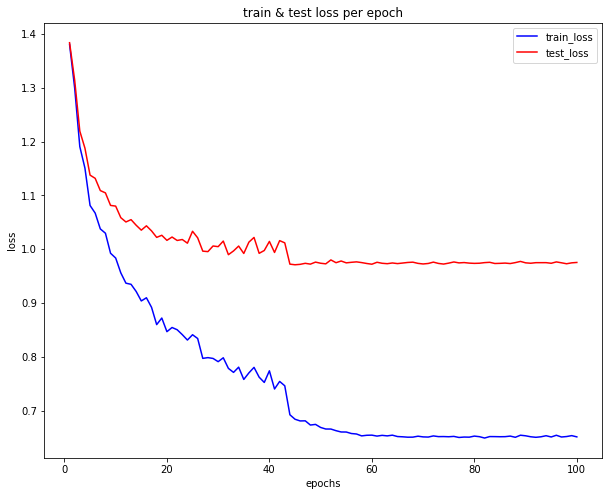

In [13]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_loss, 'b-', label='train_loss')
plt.plot(range(1, 101), test_loss, 'r-', label='test_loss')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('train & test loss per epoch')
plt.legend()

plt.show()

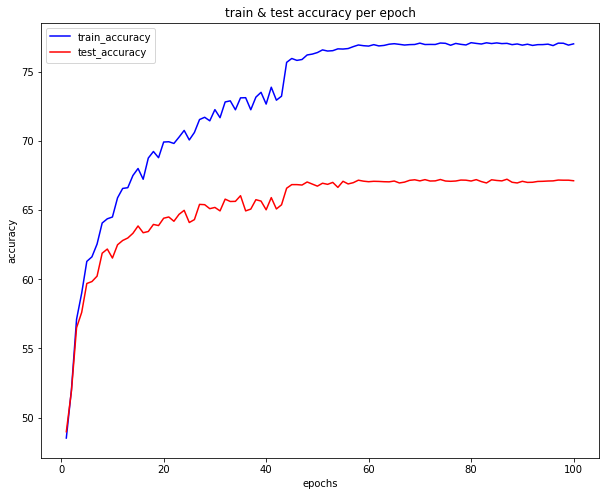

In [14]:
plt.figure(figsize=(10,8))

plt.plot(range(1, 101), train_accuracy, 'b-', label='train_accuracy')
plt.plot(range(1, 101), test_accuracy, 'r-', label='test_accuracy')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('train & test accuracy per epoch')
plt.legend()

plt.show()

In [15]:
print(f'Best epoch: {best_epoch}')
print(f'Train: accuracy: {best_train_accuracy:>0.1f}%, avg loss: {best_train_loss:>8f}')
print(f'Test: accuracy: {best_test_accuracy:>0.1f}%, avg loss: {best_test_loss:>8f}')

Best epoch: 87
Train: accuracy: 77.1%, avg loss: 0.652460
Test: accuracy: 67.2%, avg loss: 0.973309


## 5.4 Model metrics

In [16]:
print(f'Train:\n{classification_report(best_train_y, best_train_pred, target_names=target_names)}')
print(f'Test:\n{classification_report(best_test_y, best_test_pred, target_names=target_names)}')

Train:
              precision    recall  f1-score   support

    airplane       0.81      0.82      0.81      5000
  automobile       0.88      0.89      0.89      5000
        bird       0.69      0.67      0.68      5000
         cat       0.58      0.55      0.57      5000
        deer       0.74      0.73      0.73      5000
         dog       0.65      0.61      0.63      5000
        frog       0.82      0.87      0.84      5000
       horse       0.81      0.80      0.81      5000
        ship       0.84      0.91      0.88      5000
       truck       0.86      0.86      0.86      5000

    accuracy                           0.77     50000
   macro avg       0.77      0.77      0.77     50000
weighted avg       0.77      0.77      0.77     50000

Test:
              precision    recall  f1-score   support

    airplane       0.69      0.70      0.70      1000
  automobile       0.80      0.79      0.79      1000
        bird       0.55      0.54      0.54      1000
         ca

<AxesSubplot:>

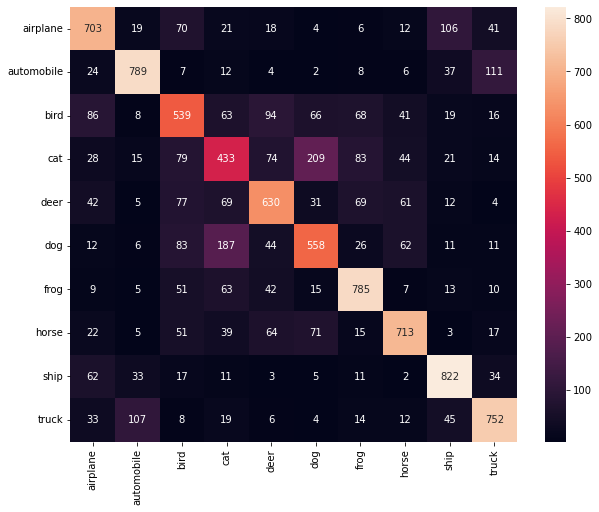

In [17]:
cm = confusion_matrix(best_test_y, best_test_pred)
sns.heatmap(cm, annot=True, fmt='', xticklabels=target_names, yticklabels=target_names, ax=plt.subplots(figsize=(10,8))[1])

## 5.5 Save model

In [18]:
torch.save(best_model_state_dict, '../saved-model/cnn-weights.pth')